## Gait Video Study 
### Validating the estimates 3D poses via CoP computed on the treadmill 
### This code qualitatively and quantitatively validates the center of mass trajectory of estimates body coordinates with their respective treadmill extracted CoP's on a frame by frame basis

We will do qualitative and quantitative validation for CoP. 
* First, we need to align the treadmill GaitCycles.csv file to the video time. This will help us align the corresponding video frames to the gait events i.e. HSR/HSL/TOR and TOL to be specific. 
* Once we know for each video, which frame numbers correspond to heel strikes and toe offs, we compute the sequence of frames that are in single support left phase, frames that are in single support right phase and similarly in double support phase. Thus, each frame of a video is labelled to be in SSR, SSL or DS phase. 
* Now, for each frame in DS phase, use the computed real world x, y coordinates for big toe, small toe and heel to make 2 triangular regions for both left and right feet, since in this phase, both feet are on ground and thus impact the center of pressure. Now, plot the corresponding actual COPX, COPY coordinate (as a red dot) for this particular frame. If this red dot lies in the shaded region of computed CoP drawn, we are good to claim that actual CoP lies in the approximate computed CoP region. Similarly, for each frame in the SSL phase, since left foot rests on ground for this phase, the CoP must be determined using the left foot, and hence use the computed x, y coordinates of the left big toe, small toe and heel to draw a shaded triangular region spanned by CoP for this frame, and draw the red dot for the actual x, y of CoP for this frame and if it lies within the shaded region, we are good to claim that actual and computed CoP region match. Now, for each frame in SSR phase, the shaded CoP region must be determined using the right feet's big/small toe and heel's x, y coordinates and if the actual CoP's x, y is bounded in this shaded computed CoP's region, we are good. 

* For qualitative validation, we plot these above mentioned regions for computed CoP and actual CoPs as markers in/out of that region for each video. If we do this for a complete stride, it should follow a butterfly pattern. And hence the inverted triangles and hexagons should occur in a butterfly pattern.
* For quantitative validation, we will call it success (1) if the actual CoP is bounded by the computed CoP shaded region and failure (0) otherwise for every frame of every video for every trial and cohort. 
* Further, for more precise quantitative validation, we can find the lateral, anterior-posterior and euclidean distance of the actual (COP_x, COP_y) with the centroid of our region drawn. This gives us a numerical value quantifying the error in the true and predicted CoP. This step can especially be done for only wrongly predicted values, to further check what is the measure of wrongly predicted values. Further, we may check that we may have error most in the lateral direction or most in the AP direction or eucliean only. 
* Based on the statistics of these success and failure counts, we can quantify the performance of our marker estimation framework using CoP validation. 
* Further, we can try to correlate/have a look at the distribution pattern to relate the correctness of CoP (either quantified using binary scores or using the numerical scores) with the confidence scores predicted by the OpenPose algorithm. Now, since we are only using toes and heel coordinates to draw the CoM trajectory/region, we should only use the confidence scores for heel and toes for this correlation. To be precise, we can average the confidence scores of left feet's heel and 2 toes to get the aggregated confidence score for frames in left single support, similarly, we can average the confidence scores of right feet's heel and 2 toes to get the aggregated confidence score for frames in right single support, and average the confidence scores of both the left and right feet's heel and toes to get the aggregated confidence scores for frames in double support. Now this correlation/relation between the confidence score for each frame and it's coorsponding correctness of CoP metric can be either done on a frame by frame basis. Or rather we can aggreagte all frames over a stride and do the relationship analysis on a stride by stride basis based on some aggregatd confidence scores of stride with some aggregated correctness of CoP score over each stride. 

In [1]:
from importlib import reload
import imports 
reload(imports)
from imports import *
from shapely.geometry.polygon import Polygon
from shapely.geometry import asPolygon, asPoint, asMultiPoint #Shapely helps find centroid of polygons 
import geopandas as gpd #For plotting shapely objects 

In [71]:
#Folder for CoP validation
cop_path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\CoPvalidation\\'
#Path to store the new dataframes to be created for CoP validation 
path_viz_dataframes = cop_path + 'CoP_dataframes_for_viz\\'
#Path for CoP validation dataframes without hip height normalization
path_viz_dataframes_non_normalized = path_viz_dataframes+'non_hip_height_normalized\\'
#Path to log file corresponding to the sync files between frame numbers and treadmill identified events for each video
sync_log_file = cop_path + 'treamill_video_cop_sync.csv'

#Path to save the vizualization plots 
save_viz_path = cop_path+'CoPviz_plots\\'

coordinate_cols = ['left toe 1-x', 'left toe 1-y', 'left toe 1-conf', 'left toe 2-x', \
                      'left toe 2-y', 'left toe 2-conf', 'left heel-x', 'left heel-y', 'left heel-conf', 'right toe 1-x', 'right toe 1-y',\
                       'right toe 1-conf', 'right toe 2-x', 'right toe 2-y', 'right toe 2-conf', 'right heel-x', 'right heel-y', \
                       'right heel-conf']
coordinate_cols_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'right toe 1-x', 'right toe 2-x', 'right heel-x']
coordinate_cols_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'right toe 1-y', 'right toe 2-y', 'right heel-y']

### Utility functions

In [3]:
def is_point_in_path(x: int, y: int, poly) -> bool:
    """
    Determine if the point is in the path.
    References: 
        https://wrf.ecse.rpi.edu//Research/Short_Notes/pnpoly.html
        https://en.wikipedia.org/wiki/Even%E2%80%93odd_rule
    Args:
      x -- The x coordinates of point.
      y -- The y coordinates of point.
      poly -- a list of tuples [(x, y), (x, y), ...]

    Returns:
      True if the point is in the path.
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                  (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [4]:
def distances(centroid, treadmill_cop):
    euclidean_dist = np.linalg.norm(centroid - treadmill_cop)
    lateral_dist = centroid[0] - treadmill_cop[0] #Raw difference between x axis (We may need to use absolute values for results)
    anterior_posterior_dist = centroid[1] - treadmill_cop[1] #Raw difference between y axis (We may need to use absolute values for results)
    return euclidean_dist, lateral_dist, anterior_posterior_dist

### main()

In [5]:
#We are going to do qualitative and quantitative analysis only for W and WT trials for this paper  
sync_log = pd.read_csv(sync_log_file, index_col = 0)
sync_log = sync_log[sync_log['Sync']=='Exists']

#Separating the videos by trial (W and WT)
sync_log_trialW = sync_log[sync_log.scenario == 'W']
sync_log_trialWT = sync_log[sync_log.scenario == 'WT']

In [6]:
%matplotlib widget

In [7]:
#Triangular region of the left foot
left_foot_coordinates_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'left toe 1-x'] 
left_foot_coordinates_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'left toe 1-y']
left_foot_confidences = ['left toe 1-conf', 'left toe 2-conf', 'left heel-conf']

#Triangular region of the right foot
right_foot_coordinates_x = ['right toe 1-x', 'right toe 2-x', 'right heel-x', 'right toe 1-x'] 
right_foot_coordinates_y =  ['right toe 1-y', 'right toe 2-y', 'right heel-y', 'right toe 1-y']
right_foot_confidences = ['right toe 1-conf', 'right toe 2-conf', 'right heel-conf']

#Hexagon of both feet together 
both_foot_coordinates_x = ['left toe 1-x', 'left toe 2-x', 'left heel-x', 'right heel-x', 'right toe 2-x', 'right toe 1-x', 'left toe 1-x'] 
both_foot_coordinates_y = ['left toe 1-y', 'left toe 2-y', 'left heel-y', 'right heel-y', 'right toe 2-y', 'right toe 1-y', 'left toe 1-y'] 
#Joining the big toe and heel of left and right feet in the hexagon to identify individual triangular feet as well 
both_foot_single_join_left_x = ['left toe 1-x', 'left heel-x']
both_foot_single_join_left_y = ['left toe 1-y', 'left heel-y']
both_foot_single_join_right_x = ['right toe 1-x', 'right heel-x']
both_foot_single_join_right_y = ['right toe 1-y', 'right heel-y']
both_foot_confidences = left_foot_confidences + right_foot_confidences

In [8]:
def plot(viz_file, video, non_normalized = False):
    plt.figure(figsize = (10, 10))
    for i in range(len(viz_file)):
        viz_file_index = viz_file.iloc[i]
        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
        plt.plot(x, y, '*--')
        plt.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], '*')
    if non_normalized:
        plt.savefig(save_viz_path+video+'_non_normalized.png', dpi = 300)
    else:
        plt.savefig(save_viz_path+video+'.png', dpi = 300)
    #     plt.show()

In [9]:
#Normalized trial W
for idx in range(len(sync_log_trialW)):
    index = sync_log_trialW.iloc[idx]
    video = index['video']
    #Frame wise vizualization file for each video
    viz_file = pd.read_csv(path_viz_dataframes+video+'.csv', index_col = 0)
    #Grouped by support type 
    viz_file_grouped = pd.read_csv(path_viz_dataframes+video+'_grouped_by_support_type.csv', index_col = 0)
#     display(viz_file.head())
    plot(viz_file, video)
#     break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
#Normalized trial WT 
for idx in range(len(sync_log_trialWT)):
    index = sync_log_trialWT.iloc[idx]
    video = index['video']
    #Frame wise vizualization file for each video
    viz_file = pd.read_csv(path_viz_dataframes+video+'.csv', index_col = 0)
    #Grouped by support type 
    viz_file_grouped = pd.read_csv(path_viz_dataframes+video+'_grouped_by_support_type.csv', index_col = 0)
#     display(viz_file.head())
    plot(viz_file, video)
#     break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
sync_log_trialW, sync_log_trialW.shape, sync_log_trialWT, sync_log_trialWT.shape

(            video    Sync  total_frame_count cohort trial scenario
 17   GVS_212_W_T2  Exists             1746.0    HOA     W        W
 18   GVS_213_W_T1  Exists             1745.0    HOA     W        W
 20   GVS_214_W_T1  Exists             1740.0    HOA     W        W
 22   GVS_215_W_T1  Exists             1739.0    HOA     W        W
 25   GVS_216_W_T2  Exists             1744.0    HOA     W        W
 26   GVS_217_W_T1  Exists             1736.0    HOA     W        W
 29   GVS_218_W_T2  Exists             1756.0    HOA     W        W
 31   GVS_219_W_T2  Exists             1738.0    HOA     W        W
 46   GVS_310_W_T1  Exists             1821.0     MS     W        W
 48   GVS_311_W_T1  Exists             1796.0     MS     W        W
 50   GVS_312_W_T2  Exists             1740.0     MS     W        W
 51   GVS_313_W_T1  Exists             1777.0     MS     W        W
 53   GVS_314_W_T1  Exists             1743.0     MS     W        W
 55   GVS_318_W_T1  Exists              728.0   

In [7]:
#Non normalized trial W
for idx in range(len(sync_log_trialW)):
    index = sync_log_trialW.iloc[idx]
    video = index['video']
    #Frame wise vizualization file for each video
    viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
    #Grouped by support type 
    viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
#     display(viz_file.head())
    plot(viz_file, video, non_normalized=True)
#     break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
#Non normalized trial WT
for idx in range(len(sync_log_trialWT)):
    index = sync_log_trialWT.iloc[idx]
    video = index['video']
    #Frame wise vizualization file for each video
    viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
    #Grouped by support type 
    viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
#     display(viz_file.head())
    plot(viz_file, video, non_normalized=True)
#     break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [95]:
def plot_frame_wise(viz_file, video, non_normalized = False):
    print (viz_file[coordinate_cols].isna().any(axis = 1).sum())
    count_inside = 0
    eucl_dist_list, lat_dist_list, ap_dist_list = [], [], []
    colormap = np.array(['cornflowerblue', 'b', 'cyan'])
    #For the true butterfly diagram for the current stride 
#     HSR_indices = viz_file[viz_file.EventType=='HSR'].index
    
    for i in range(len(viz_file)):
        viz_file_index = viz_file.iloc[i]
        #For the true butterfly diagram for the current stride 
#         try:
#             stride_limits = range(HSR_indices[HSR_indices<=i][-1], HSR_indices[HSR_indices>i][0]+1)
#         except:
#             stride_limits = range(HSR_indices[HSR_indices<=i][-1], len(viz_file)) #For the last HSR 

        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
            categories = np.array([0, 1, 2, 2, 1, 0])
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
            categories = np.array([0, 1, 2])
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
            categories = np.array([0, 1, 2])
        poly_xy = [(x_, y_) for x_, y_ in zip(x, y)]
        point_inside = is_point_in_path(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], poly_xy)
        print (viz_file_index.support_type, point_inside)
        if point_inside:
            count_inside+=1
#         plt.figure()
#         plt.plot(x, y, '*--')    
        fig, ax = plt.subplots(figsize = (15, 6))
        p = asPolygon(poly_xy)
        #For the true butterfly diagram for the current stride 
#         ax.plot(viz_file.iloc[stride_limits]['treadmill_COP_x'], viz_file.iloc[stride_limits]['treadmill_COP_y'], 'k-')
        p1 = gpd.GeoSeries(p)
        p_centroid = p.centroid
        eucl_dist, lat_dist, ap_dist = distances(np.array(p_centroid), viz_file.iloc[i][['treadmill_COP_x', 'treadmill_COP_y']].values)
        eucl_dist_list.append(eucl_dist)
        lat_dist_list.append(lat_dist)
        ap_dist_list.append(ap_dist)
        p2 = gpd.GeoSeries(p_centroid)
        p1.plot(edgecolor='black', color = 'aliceblue', ax= ax, linestyle = '--')
        ax.scatter(p.exterior.xy[0][:-1], p.exterior.xy[1][:-1], marker = 'o', s = 50, linestyle = 'None', c = colormap[categories], edgecolor = 'grey')
        p2.plot(ax = ax, color = 'lime', marker = 'X', markersize = 100, edgecolor = 'grey')
        ax.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], 'r', marker = '*', markersize = 10)
        print ('Euclidean, Lateral and AP distance from centroid (in cm): ', eucl_dist, lat_dist, ap_dist)
        if non_normalized:
            plt.savefig(save_viz_path+'\\frame_wise_viz\\'+video+'_non_normalized_' + str(i) + str(point_inside) + '.png', dpi = 300)
        else:
            plt.savefig(save_viz_path+'\\frame_wise_viz\\'+video+'_' + str(i) + str(point_inside) + '.png', dpi = 300)
        plt.show()
    print ('No. of CoPs lying inside polygons are:', count_inside, ' out of ', len(viz_file))
    print ('Average euclidean, lateral and AP distance from centroid in cm: ', np.mean(eucl_dist_list), np.mean(lat_dist_list), \
           np.mean(ap_dist_list))
    print ('Standard deviation in euclidean, lateral and AP distance from centroid in cm: ', np.std(eucl_dist_list), np.std(lat_dist_list), \
           np.std(ap_dist_list))  
    #Absolute lateral and anterior-posterior distance 
    lat_dist_list_abs = list(map(abs, lat_dist_list))
    ap_dist_list_abs = list(map(abs, ap_dist_list))
    print ('Average absolute lateral and AP distance from centroid in cm: ', np.mean(lat_dist_list_abs), \
       np.mean(ap_dist_list_abs))
    print ('Standard deviation of absolute lateral and AP distance from centroid in cm: ', np.std(lat_dist_list_abs), \
       np.std(ap_dist_list_abs))  

In [91]:
idx = 0
index = sync_log_trialW.iloc[idx]
video = index['video']
print (video)
#Frame wise vizualization file for each video
viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
#Handle NaNs in viz_file for frames with body coordinates not detected by OpenPose 
viz_file= viz_file.iloc[viz_file[coordinate_cols].dropna().index]
#Grouped viz file by support type
viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)

GVS_212_W_T2


In [11]:
# plt.figure(figsize = (10, 10))
# for i in range(len(viz_file)):
#     viz_file_index = viz_file.iloc[i]
#     if  ((viz_file_index.support_type =='initialDS')| (viz_file_index.support_type =='terminal DS')):
#         x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
#     elif viz_file_index.support_type =='rightSS':
#         x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
#     else:
#         x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
#     plt.plot(x, y, '*--')
#     plt.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], '*')

In [12]:
%matplotlib inline

In [39]:
def compute_OpenPose_treadmill_shift(viz_file_grouped, video):
    print ('NaN body coordinates:', viz_file_grouped[coordinate_cols].isna().any(axis = 1).sum())
    colormap = np.array(['cornflowerblue', 'b', 'cyan'])
    viz_file_grouped_for_shift = copy.deepcopy(viz_file_grouped)
    viz_file_grouped_for_shift['centroid_x'] = np.nan
    viz_file_grouped_for_shift['centroid_y'] = np.nan
    for i in range(len(viz_file_grouped_for_shift)):
        viz_file_index = viz_file_grouped_for_shift.iloc[i]
        if  ((viz_file_index.support_type =='initial DS')| (viz_file_index.support_type =='terminal DS')):
            x, y =  viz_file_index[both_foot_coordinates_x],  viz_file_index[both_foot_coordinates_y]
            categories = np.array([0, 1, 2, 2, 1, 0])
        elif viz_file_index.support_type =='right SS':
            x, y =  viz_file_index[right_foot_coordinates_x],  viz_file_index[right_foot_coordinates_y]
            categories = np.array([0, 1, 2])
        else:
            x, y =  viz_file_index[left_foot_coordinates_x],  viz_file_index[left_foot_coordinates_y]
            categories = np.array([0, 1, 2])
        poly_xy = [(x_, y_) for x_, y_ in zip(x, y)]
        p = asPolygon(poly_xy)
        p_centroid = p.centroid
        p_centroid_x = np.array(p_centroid)[0]
        p_centroid_y = np.array(p_centroid)[1]
        #Checking if the computed centroid is genuine and lies inside the polygon
        #If the computed centroid is not genuine, we keep centroid as NaN and drop the respective row later from analysis 
        #to avoid outlier errors in computing the shift value or quantitative errors between centroid and treadmill's COP
        centroid_inside = is_point_in_path(p_centroid_x, p_centroid_y, poly_xy)
        if centroid_inside:
            viz_file_grouped_for_shift['centroid_x'].iloc[i] = p_centroid_x
            viz_file_grouped_for_shift['centroid_y'].iloc[i] = p_centroid_y
        
#         fig, ax = plt.subplots(figsize = (6, 10))
#         p1 = gpd.GeoSeries(p)
#         p2 = gpd.GeoSeries(p_centroid)
#         p1.plot(edgecolor='black', color = 'aliceblue', ax= ax, linestyle = '--')
#         ax.scatter(p.exterior.xy[0][:-1], p.exterior.xy[1][:-1], marker = 'o', s = 50, linestyle = 'None', c = colormap[categories], edgecolor = 'grey')
#         p2.plot(ax = ax, color = 'lime', marker = 'X', markersize = 100, edgecolor = 'grey')
#         ax.plot(viz_file_index['treadmill_COP_x'], viz_file_index['treadmill_COP_y'], 'r', marker = '*', markersize = 10)
#         ax.set_xlim((0, 60))
#         ax.set_ylim((100, 300))
#         plt.savefig(save_viz_path+'\\support_group_wise_viz\\'+video+'_non_normalized_' + str(i) + '.png', dpi = 300)
    #Deleting the rows with centroids lying outside the polygon shape 
    viz_file_grouped_for_shift.drop(viz_file_grouped_for_shift[viz_file_grouped_for_shift[['centroid_x', 'centroid_y']].isna().any(axis = 1)].index, inplace = True)
    return viz_file_grouped_for_shift

In [63]:
shift = pd.DataFrame (columns = ['video_name', 'median_diff_x', 'median_diff_y'])
for idx in range(len(sync_log_trialW)):
    index = sync_log_trialW.iloc[idx]
    video = index['video']
    print (video)
    #Grouped viz file by support type
    viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
    #Handle NaNs in viz_file for support groups with body coordinates not detected by OpenPose 
    viz_file_grouped = viz_file_grouped.iloc[viz_file_grouped[coordinate_cols].dropna().index]
    viz_file_grouped_for_shift = compute_OpenPose_treadmill_shift(viz_file_grouped, video)
    diff_x = viz_file_grouped_for_shift.treadmill_COP_x - viz_file_grouped_for_shift.centroid_x
    display (diff_x.describe())

    diff_y = viz_file_grouped_for_shift.treadmill_COP_y - viz_file_grouped_for_shift.centroid_y
    display (diff_y.describe())
    shift.loc[len(shift)] = [video, diff_x.median(), diff_y.median()]

GVS_212_W_T2
NaN body coordinates: 0


count    206.000000
mean       8.795174
std        2.750401
min        1.706377
25%        6.864628
50%        9.209938
75%       10.656161
max       14.836657
dtype: float64

count    206.000000
mean       1.199668
std        6.564694
min      -18.715846
25%       -3.939738
50%        1.812395
75%        6.076680
max       15.921155
dtype: float64

GVS_213_W_T1
NaN body coordinates: 0


count    139.000000
mean      11.008480
std        2.572418
min        4.219315
25%        9.378129
50%       10.676478
75%       12.617442
max       21.381585
dtype: float64

count    139.000000
mean       2.432335
std        4.366974
min       -5.049554
25%       -0.220069
50%        2.002727
75%        4.213879
max       30.763579
dtype: float64

GVS_214_W_T1
NaN body coordinates: 0


count    194.000000
mean      10.920021
std        6.488769
min       -0.032368
25%        5.048965
50%       10.114416
75%       16.663382
max       23.399676
dtype: float64

count    194.000000
mean       5.290692
std       12.918806
min      -29.172749
25%       -3.871314
50%        7.046648
75%       14.957762
max       35.865649
dtype: float64

GVS_215_W_T1
NaN body coordinates: 0


count    195.000000
mean       9.265648
std        3.805884
min        0.603687
25%        6.194059
50%        9.425297
75%       12.372686
max       17.148410
dtype: float64

count    195.000000
mean       6.458929
std        4.841631
min       -5.894134
25%        3.223496
50%        6.728535
75%        9.752487
max       22.117663
dtype: float64

GVS_216_W_T2
NaN body coordinates: 0


count    227.000000
mean       9.159452
std        4.797049
min       -1.771089
25%        5.417591
50%        8.727246
75%       12.970217
max       19.151279
dtype: float64

count    227.000000
mean      10.996389
std        9.416118
min      -32.162291
25%        6.550639
50%       12.164225
75%       16.639681
max       41.760227
dtype: float64

GVS_217_W_T1
NaN body coordinates: 0


count    176.000000
mean       5.647844
std        6.271663
min      -11.242610
25%        1.125193
50%        5.423031
75%       10.340478
max       18.447842
dtype: float64

count    176.000000
mean     -28.143845
std        6.915070
min      -43.300015
25%      -33.329540
50%      -28.757438
75%      -22.834303
max       -5.118468
dtype: float64

GVS_218_W_T2
NaN body coordinates: 0


count    211.000000
mean       9.891735
std        4.745658
min       -4.729199
25%        7.368219
50%       10.397795
75%       12.548804
max       26.186476
dtype: float64

count    211.000000
mean       2.749845
std        9.143491
min      -33.483908
25%       -2.149097
50%        4.080489
75%        8.685031
max       33.208668
dtype: float64

GVS_219_W_T2
NaN body coordinates: 0


count    214.000000
mean       9.941759
std        5.389687
min       -9.935985
25%        7.678367
50%       10.907955
75%       13.444612
max       20.386270
dtype: float64

count    214.000000
mean       6.013420
std       15.905265
min      -37.141031
25%       -2.374602
50%        5.483417
75%       17.574516
max       65.867577
dtype: float64

GVS_310_W_T1
NaN body coordinates: 0


count    155.000000
mean       9.035589
std        3.044675
min        0.315720
25%        7.177496
50%        9.031133
75%       11.096726
max       15.422411
dtype: float64

count    155.000000
mean      -4.432182
std        8.672179
min      -25.768272
25%      -10.244159
50%       -5.204470
75%        1.451851
max       34.622273
dtype: float64

GVS_311_W_T1
NaN body coordinates: 0


count    187.000000
mean       8.164309
std        3.714277
min       -2.298456
25%        5.659425
50%        7.987330
75%       10.895619
max       22.172387
dtype: float64

count    187.000000
mean     -13.057659
std       12.172510
min      -48.503743
25%      -18.443795
50%       -9.327468
75%       -4.120368
max        5.752165
dtype: float64

GVS_312_W_T2
NaN body coordinates: 0


count    195.000000
mean       8.574267
std        4.613272
min       -1.205795
25%        4.395559
50%        8.721469
75%       12.544102
max       18.046676
dtype: float64

count    195.000000
mean       0.615585
std       12.748335
min      -23.971246
25%      -10.972811
50%       -1.541225
75%       13.112590
max       22.173106
dtype: float64

GVS_313_W_T1
NaN body coordinates: 0


count    123.000000
mean       6.071912
std        5.334815
min      -13.822992
25%        2.898370
50%        5.457073
75%       10.962406
max       18.286762
dtype: float64

count    123.000000
mean      -5.811641
std        8.734745
min      -40.364576
25%      -10.131586
50%       -3.685916
75%       -0.312091
max       10.206823
dtype: float64

GVS_314_W_T1
NaN body coordinates: 0


count    135.000000
mean       7.889308
std        4.421714
min       -3.217341
25%        4.380350
50%        7.877492
75%       12.224464
max       15.086729
dtype: float64

count    135.000000
mean      -6.149264
std        8.024632
min      -34.929600
25%      -11.385062
50%       -6.860663
75%        0.951411
max        8.980889
dtype: float64

GVS_318_W_T1
NaN body coordinates: 0


count    31.000000
mean     10.459660
std       3.234011
min       4.789356
25%       8.232024
50%      10.404528
75%      12.612544
max      17.693626
dtype: float64

count    31.000000
mean     -1.333390
std       3.439643
min      -8.915448
25%      -4.203494
50%      -2.209519
75%       1.750380
max       4.058679
dtype: float64

GVS_320_W_T1
NaN body coordinates: 0


count    167.000000
mean       7.543513
std        4.052342
min       -3.940551
25%        5.207458
50%        7.620168
75%        9.666192
max       21.200978
dtype: float64

count    167.000000
mean       6.358079
std       13.279208
min      -18.401191
25%       -3.640275
50%        4.068819
75%       20.135516
max       35.498940
dtype: float64

GVS_321_W_T1
NaN body coordinates: 0


count    99.000000
mean      5.671092
std       3.369765
min      -3.417821
25%       3.006839
50%       5.790660
75%       7.938086
max      13.743598
dtype: float64

count    99.000000
mean    -16.984166
std       4.786719
min     -30.272742
25%     -20.628632
50%     -15.835317
75%     -13.388711
max      -8.750448
dtype: float64

GVS_322_W_T2
NaN body coordinates: 0


count    147.000000
mean       8.221774
std        4.318597
min       -1.740098
25%        4.933637
50%        8.888832
75%       11.176977
max       18.823379
dtype: float64

count    147.000000
mean     -11.705755
std       10.287874
min      -37.993768
25%      -20.178491
50%      -10.365782
75%       -3.903859
max       11.108061
dtype: float64

GVS_323_W_T1
NaN body coordinates: 0


count    230.000000
mean       6.473840
std        4.992955
min       -9.485028
25%        2.662754
50%        5.999756
75%       10.852817
max       16.455809
dtype: float64

count    230.000000
mean     -10.783094
std       14.445618
min      -48.856317
25%      -22.613147
50%      -16.615836
75%        3.358898
max       34.291090
dtype: float64

GVS_404_W_T2
NaN body coordinates: 0


count    225.000000
mean       3.712382
std        4.129079
min       -5.827789
25%        0.574928
50%        3.121479
75%        6.799793
max       18.665117
dtype: float64

count    225.000000
mean     -33.423136
std       16.084459
min      -72.569680
25%      -44.778469
50%      -33.343303
75%      -19.768815
max       -1.850414
dtype: float64

GVS_404_W_T3
NaN body coordinates: 0


count    287.000000
mean       4.667348
std        4.147301
min       -4.139069
25%        1.631342
50%        3.971251
75%        7.524981
max       24.128801
dtype: float64

count    287.000000
mean     -52.614126
std       14.963844
min     -141.427276
25%      -56.456770
50%      -50.973565
75%      -43.467190
max      -34.926539
dtype: float64

GVS_405_W_T1
NaN body coordinates: 0


count    91.000000
mean     11.633506
std       5.099410
min      -0.240981
25%       7.648613
50%      10.588828
75%      15.689658
max      27.623654
dtype: float64

count    91.000000
mean     -2.403801
std       5.554415
min     -14.881522
25%      -6.827693
50%      -1.475949
75%       2.029387
max       7.161727
dtype: float64

GVS_405_W_T3
NaN body coordinates: 0


count    47.000000
mean     11.481155
std       6.436369
min      -3.415287
25%       7.222442
50%      12.446242
75%      15.737977
max      25.869784
dtype: float64

count    47.000000
mean      3.625931
std       7.222188
min     -10.831316
25%      -1.818441
50%       2.956106
75%       8.645594
max      19.633377
dtype: float64

GVS_406_W_T2
NaN body coordinates: 0


count    177.000000
mean       9.658865
std        3.735496
min       -5.218569
25%        7.651652
50%        9.711544
75%       12.148764
max       18.752149
dtype: float64

count    177.000000
mean       6.038013
std        7.763396
min      -23.147227
25%        1.224853
50%        6.208942
75%       11.740725
max       20.773694
dtype: float64

GVS_408_W_T2
NaN body coordinates: 0


count    191.000000
mean      10.058421
std        4.116656
min       -0.787822
25%        7.470254
50%        9.697838
75%       13.968411
max       17.329868
dtype: float64

count    191.000000
mean      -3.224776
std       10.414481
min      -25.908451
25%      -11.697901
50%       -3.300827
75%        6.110097
max       20.273363
dtype: float64

GVS_409_W_T2
NaN body coordinates: 0


count    187.000000
mean       8.898091
std        2.487481
min        2.530346
25%        7.068684
50%        8.943323
75%       10.337831
max       15.091057
dtype: float64

count    187.000000
mean     -23.955804
std        9.321372
min      -44.826195
25%      -31.671129
50%      -23.057175
75%      -18.090299
max        1.211650
dtype: float64

GVS_410_W_T1
NaN body coordinates: 0


count    163.000000
mean       6.345017
std        3.435007
min       -1.187967
25%        4.196922
50%        5.842728
75%        8.109264
max       14.475382
dtype: float64

count    163.000000
mean     -31.833109
std       15.205369
min      -59.288616
25%      -41.107976
50%      -33.738865
75%      -26.055646
max       21.521575
dtype: float64

GVS_411_W_T1
NaN body coordinates: 0


count    230.000000
mean       9.319153
std        5.483097
min       -7.558602
25%        5.298371
50%        8.896916
75%       13.172298
max       29.146944
dtype: float64

count    230.000000
mean     -29.593439
std       16.063654
min      -59.184577
25%      -42.546703
50%      -29.090467
75%      -17.462829
max       19.334481
dtype: float64

GVS_411_W_T3
NaN body coordinates: 0


count    208.000000
mean       6.076032
std        3.249401
min       -0.940525
25%        4.040804
50%        6.141073
75%        8.155076
max       16.979180
dtype: float64

count    208.000000
mean     -35.035492
std       16.023719
min      -67.248895
25%      -49.047894
50%      -35.261954
75%      -24.134231
max       10.504029
dtype: float64

GVS_102_W_T1
NaN body coordinates: 0


count    351.000000
mean      -0.466010
std        3.698516
min      -14.307737
25%       -2.624335
50%       -0.606196
75%        1.924789
max       12.521712
dtype: float64

count    351.000000
mean     -50.189973
std        5.984249
min      -65.572545
25%      -53.370880
50%      -49.843236
75%      -46.456207
max      -35.228494
dtype: float64

GVS_112_W_T1
NaN body coordinates: 0


count    390.000000
mean       0.361038
std        2.839691
min       -5.240056
25%       -2.291583
50%        0.299051
75%        2.917714
max        6.842664
dtype: float64

count    390.000000
mean     -17.651890
std        8.911230
min      -38.854315
25%      -23.893816
50%      -20.284429
75%       -9.529775
max        1.686636
dtype: float64

GVS_113_W_T1
NaN body coordinates: 0


count    235.000000
mean       0.641676
std        4.178972
min       -9.829197
25%       -2.379877
50%        0.724627
75%        3.864053
max       12.620782
dtype: float64

count    235.000000
mean     -22.841620
std        5.031169
min      -37.015379
25%      -26.540738
50%      -22.581937
75%      -19.110208
max      -11.996492
dtype: float64

GVS_115_W_T1
NaN body coordinates: 0


count    331.000000
mean       0.079019
std        2.866211
min       -6.401563
25%       -2.537828
50%       -0.078345
75%        2.732935
max        6.347684
dtype: float64

count    331.000000
mean     -26.638242
std       11.942606
min      -37.250381
25%      -33.207636
50%      -31.522490
75%      -27.664470
max        9.413426
dtype: float64

GVS_123_W_T1
NaN body coordinates: 0


count    399.000000
mean      -1.017695
std        4.086529
min      -14.153837
25%       -3.547106
50%       -0.989356
75%        2.010238
max        9.960668
dtype: float64

count    399.000000
mean     -15.893172
std       12.960962
min      -38.785324
25%      -24.244140
50%      -17.693654
75%      -10.028679
max       24.753890
dtype: float64

GVS_124_W_T1
NaN body coordinates: 0


count    243.000000
mean       0.390443
std        3.044884
min       -6.736556
25%       -1.914663
50%        0.667299
75%        2.531722
max       11.040466
dtype: float64

count    243.000000
mean      -8.404893
std        6.953258
min      -25.713636
25%      -12.283839
50%       -9.581785
75%       -5.893750
max       17.647942
dtype: float64

In [65]:
for idx in range(len(sync_log_trialWT)):
    index = sync_log_trialWT.iloc[idx]
    video = index['video']
    print (video)
    #Grouped viz file by support type
    viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)
    #Handle NaNs in viz_file for support groups with body coordinates not detected by OpenPose 
    viz_file_grouped = viz_file_grouped.iloc[viz_file_grouped[coordinate_cols].dropna().index]
    viz_file_grouped_for_shift = compute_OpenPose_treadmill_shift(viz_file_grouped, video)
    diff_x = viz_file_grouped_for_shift.treadmill_COP_x - viz_file_grouped_for_shift.centroid_x
    display (diff_x.describe())

    diff_y = viz_file_grouped_for_shift.treadmill_COP_y - viz_file_grouped_for_shift.centroid_y
    display (diff_y.describe())
    shift.loc[len(shift)] = [video, diff_x.median(), diff_y.median()]

GVS_212_W_T1
NaN body coordinates: 0


count    203.000000
mean       8.445018
std        3.933069
min        0.065840
25%        5.548457
50%        8.404786
75%       11.298068
max       18.038051
dtype: float64

count    203.000000
mean       5.151313
std        8.796357
min      -29.160437
25%       -0.142808
50%        3.799552
75%       11.551219
max       32.015760
dtype: float64

GVS_213_W_T2
NaN body coordinates: 0


count    135.000000
mean      11.321757
std        2.561663
min        5.528447
25%        9.557005
50%       11.157867
75%       12.907526
max       20.459417
dtype: float64

count    135.000000
mean       5.546207
std        4.008069
min       -5.257730
25%        2.677758
50%        5.199446
75%        8.528445
max       14.822844
dtype: float64

GVS_214_W_T2
NaN body coordinates: 0


count    217.000000
mean      11.231074
std        5.463916
min       -3.702900
25%        7.658073
50%       11.183007
75%       14.827567
max       24.172725
dtype: float64

count    217.000000
mean       9.595062
std       11.027044
min      -22.716146
25%        2.347174
50%        9.216924
75%       18.787946
max       30.462995
dtype: float64

GVS_215_W_T2
NaN body coordinates: 0


count    203.000000
mean       9.341576
std        3.440341
min       -0.365145
25%        7.358166
50%        9.283542
75%       11.726280
max       18.920069
dtype: float64

count    203.000000
mean      13.545081
std       12.838478
min      -18.262996
25%        3.348869
50%       11.094927
75%       24.380040
max       48.249023
dtype: float64

GVS_216_W_T1
NaN body coordinates: 0


count    203.000000
mean       8.720666
std        4.266945
min       -0.945751
25%        5.227954
50%        8.588136
75%       11.671103
max       20.330937
dtype: float64

count    203.000000
mean      11.532243
std       10.536601
min      -34.133341
25%        8.054132
50%       12.613190
75%       17.740020
max       43.373145
dtype: float64

GVS_217_W_T2
NaN body coordinates: 0


count    187.000000
mean       5.887465
std        5.579502
min       -6.947383
25%        1.466629
50%        3.622875
75%       11.133746
max       20.333024
dtype: float64

count    187.000000
mean     -30.658458
std        8.960523
min      -49.702867
25%      -36.052526
50%      -31.713739
75%      -24.039990
max       -0.258754
dtype: float64

GVS_218_W_T1
NaN body coordinates: 0


count    186.000000
mean       9.137127
std        3.936608
min       -2.504287
25%        6.667121
50%        9.519783
75%       12.077176
max       22.111548
dtype: float64

count    186.000000
mean      -6.267868
std        9.220549
min      -28.238290
25%      -12.179500
50%       -7.922173
75%        0.220001
max       17.832420
dtype: float64

GVS_219_W_T1
NaN body coordinates: 0


count    159.000000
mean      10.296690
std        4.944034
min       -6.909400
25%        6.407796
50%       10.884775
75%       14.057484
max       22.839909
dtype: float64

count    159.000000
mean       1.408653
std       10.626545
min      -18.872071
25%       -7.055054
50%        1.316596
75%        9.225539
max       31.322922
dtype: float64

GVS_310_W_T2
NaN body coordinates: 0


count    154.000000
mean       8.249787
std        3.139879
min       -1.692363
25%        6.501314
50%        8.219082
75%       10.089952
max       17.741985
dtype: float64

count    154.000000
mean       1.203179
std       12.121586
min      -23.431140
25%       -7.942686
50%       -1.900567
75%       10.078322
max       40.108385
dtype: float64

GVS_311_W_T2
NaN body coordinates: 0


count    126.000000
mean       7.972225
std        5.796954
min       -6.977190
25%        3.446195
50%        7.976603
75%       12.665172
max       28.243718
dtype: float64

count    126.000000
mean      -3.385146
std       10.574357
min      -39.917223
25%       -9.527082
50%       -1.630313
75%        3.374594
max       25.639289
dtype: float64

GVS_313_W_T2
NaN body coordinates: 0


count    95.000000
mean      6.655829
std       5.696962
min     -14.192887
25%       3.655598
50%       7.138343
75%      10.258008
max      27.166133
dtype: float64

count    95.000000
mean     -4.055512
std      11.314839
min     -38.340588
25%     -11.172343
50%      -3.760755
75%       3.146669
max      26.838557
dtype: float64

GVS_314_W_T2
NaN body coordinates: 0


count    123.000000
mean       8.694840
std        5.656191
min       -4.817527
25%        4.231812
50%        9.103987
75%       13.021599
max       28.073022
dtype: float64

count    123.000000
mean      -8.369195
std       11.253918
min      -58.770264
25%       -9.986755
50%       -5.972294
75%       -2.234386
max        5.129911
dtype: float64

GVS_318_W_T2
NaN body coordinates: 0


count    31.000000
mean     10.246788
std       2.477629
min       6.039310
25%       7.989724
50%      10.201474
75%      12.155465
max      14.825522
dtype: float64

count    31.000000
mean     -5.679459
std       5.871886
min     -16.422013
25%      -9.910031
50%      -4.892993
75%      -1.724383
max       3.411070
dtype: float64

GVS_320_W_T2
NaN body coordinates: 0


count    190.000000
mean       8.260717
std        4.953656
min       -2.675946
25%        4.752435
50%        8.108793
75%       12.012142
max       22.347687
dtype: float64

count    190.000000
mean       7.001173
std       11.720282
min      -24.838235
25%       -1.623862
50%        6.057457
75%       17.620541
max       31.910009
dtype: float64

GVS_321_W_T2
NaN body coordinates: 0


count    159.000000
mean       9.135960
std        4.378745
min       -0.952283
25%        6.251794
50%        9.103194
75%       12.261838
max       17.669595
dtype: float64

count    159.000000
mean      -7.499667
std        8.025938
min      -32.898004
25%      -11.338076
50%       -6.841047
75%       -2.151252
max       10.738079
dtype: float64

GVS_322_W_T1
NaN body coordinates: 0


count    147.000000
mean       8.305208
std        4.453184
min      -11.376536
25%        5.376461
50%        8.093747
75%       11.215868
max       23.574083
dtype: float64

count    147.000000
mean     -13.858366
std        8.898293
min      -40.058390
25%      -19.384055
50%      -13.423053
75%       -6.744238
max        6.421877
dtype: float64

GVS_323_W_T2
NaN body coordinates: 0


count    225.000000
mean       5.728178
std        3.805083
min       -5.339026
25%        2.844974
50%        5.771240
75%        8.448913
max       20.161494
dtype: float64

count    225.000000
mean       0.442760
std        9.426757
min      -40.951396
25%       -5.036778
50%        0.943258
75%        7.287354
max       34.686716
dtype: float64

GVS_403_W_T2
NaN body coordinates: 0


count    170.000000
mean       7.953947
std        4.453487
min       -5.402880
25%        5.274037
50%        8.166909
75%       10.976016
max       18.542031
dtype: float64

count    170.000000
mean       3.862469
std        8.823939
min      -16.105279
25%       -2.626231
50%        3.226847
75%        9.982881
max       26.804389
dtype: float64

GVS_404_W_T1
NaN body coordinates: 0


count    127.000000
mean       4.202121
std        4.906925
min       -8.152361
25%        1.028499
50%        3.801636
75%        7.121447
max       21.707687
dtype: float64

count    127.000000
mean     -28.685256
std       15.823982
min      -60.476792
25%      -40.735029
50%      -32.367123
75%      -15.408594
max        4.183337
dtype: float64

GVS_404_W_T4
NaN body coordinates: 0


count    264.000000
mean       4.357985
std        4.238459
min       -6.532819
25%        1.319400
50%        4.155878
75%        7.170996
max       19.737108
dtype: float64

count    264.000000
mean     -46.011715
std       15.903129
min      -81.392202
25%      -56.535851
50%      -47.997326
75%      -37.675683
max       -9.212868
dtype: float64

GVS_405_W_T2
NaN body coordinates: 0


count    59.000000
mean     12.551988
std       5.560675
min      -6.290432
25%       9.032180
50%      12.521550
75%      16.931683
max      21.718511
dtype: float64

count    59.000000
mean     -2.613888
std       8.472326
min     -22.961761
25%      -8.473326
50%      -3.764410
75%       2.234141
max      21.144960
dtype: float64

GVS_405_W_T4
NaN body coordinates: 0


count    139.000000
mean      12.373259
std        4.278390
min        3.675865
25%        8.950135
50%       11.776481
75%       15.703473
max       24.330325
dtype: float64

count    139.000000
mean       2.352305
std        9.050081
min      -30.764736
25%       -3.306385
50%        2.262061
75%        7.425219
max       24.122395
dtype: float64

GVS_406_W_T1
NaN body coordinates: 0


count    171.000000
mean       8.950236
std        4.632104
min       -7.243467
25%        5.602407
50%        8.375291
75%       12.534423
max       20.775063
dtype: float64

count    171.000000
mean       4.495341
std       13.054541
min      -30.639033
25%       -7.595778
50%        3.932057
75%       16.411126
max       27.093991
dtype: float64

GVS_407_W_T1
NaN body coordinates: 0


count    131.000000
mean       9.106230
std        3.060007
min        1.477291
25%        6.773225
50%        9.117748
75%       11.513912
max       16.704642
dtype: float64

count    131.000000
mean      -2.627765
std        9.669238
min      -39.184493
25%       -9.383859
50%       -1.172618
75%        3.349762
max       15.222525
dtype: float64

GVS_408_W_T1
NaN body coordinates: 0


count    163.000000
mean      10.858676
std        4.189471
min       -4.649434
25%        7.608062
50%       11.262851
75%       14.833112
max       21.443637
dtype: float64

count    163.000000
mean       0.613808
std        8.234324
min      -15.279135
25%       -5.984820
50%       -0.269717
75%        8.426521
max       19.887679
dtype: float64

GVS_409_W_T1
NaN body coordinates: 0


count    185.000000
mean       8.934882
std        1.899706
min        2.584115
25%        7.594514
50%        8.829590
75%       10.590008
max       12.470070
dtype: float64

count    185.000000
mean     -24.377461
std       11.009475
min      -43.158705
25%      -32.902771
50%      -24.100796
75%      -17.338830
max       11.348224
dtype: float64

GVS_410_W_T2
NaN body coordinates: 0


count    155.000000
mean       6.044247
std        2.893681
min        0.530462
25%        4.057005
50%        6.340973
75%        7.950023
max       13.513347
dtype: float64

count    155.000000
mean     -48.834985
std        6.405925
min      -61.760016
25%      -53.135789
50%      -48.886563
75%      -46.107714
max      -16.937647
dtype: float64

GVS_411_W_T2
NaN body coordinates: 0


count    231.000000
mean       7.074523
std        3.889794
min       -1.048094
25%        4.331573
50%        5.912015
75%        9.699438
max       19.759936
dtype: float64

count    231.000000
mean     -34.729201
std       14.669654
min      -57.739224
25%      -46.182698
50%      -36.820561
75%      -27.250379
max        5.473769
dtype: float64

GVS_411_W_T4
NaN body coordinates: 0


count    223.000000
mean       7.699060
std        2.623028
min        0.395883
25%        6.210753
50%        7.212725
75%        9.179959
max       16.485343
dtype: float64

count    223.000000
mean     -41.064739
std       16.619285
min      -69.112738
25%      -55.031919
50%      -40.970143
75%      -31.632360
max        1.556906
dtype: float64

In [66]:
shift

,video_name,median_diff_x,median_diff_y
0,GVS_212_W_T2,9.209938,1.812395
1,GVS_213_W_T1,10.676478,2.002727
2,GVS_214_W_T1,10.114416,7.046648
3,GVS_215_W_T1,9.425297,6.728535
4,GVS_216_W_T2,8.727246,12.164225
5,GVS_217_W_T1,5.423031,-28.757438
6,GVS_218_W_T2,10.397795,4.080489
7,GVS_219_W_T2,10.907955,5.483417
8,GVS_310_W_T1,9.031133,-5.204470
9,GVS_311_W_T1,7.987330,-9.327468


In [99]:
idx = 0
index = sync_log_trialW.iloc[idx]
video = index['video']
print (video)
#Frame wise vizualization file for each video
viz_file = pd.read_csv(path_viz_dataframes_non_normalized+video+'.csv', index_col = 0)
#Handle NaNs in viz_file for frames with body coordinates not detected by OpenPose 
viz_file= viz_file.iloc[viz_file[coordinate_cols].dropna().index]
#Grouped viz file by support type
viz_file_grouped = pd.read_csv(path_viz_dataframes_non_normalized+video+'_grouped_by_support_type.csv', index_col = 0)

GVS_212_W_T2


In [97]:
viz_file_grouped[coordinate_cols_x]= viz_file_grouped[coordinate_cols_x]+9.2
viz_file_grouped[coordinate_cols_y]= viz_file_grouped[coordinate_cols_y]+1.8

0
initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.4251144954595913 -1.342651030728092 -0.47774421488264807


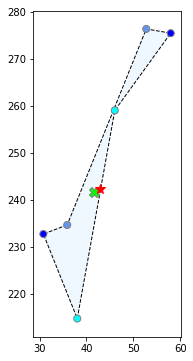

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.745387588271984 3.2418550249994027 3.4654118600552977


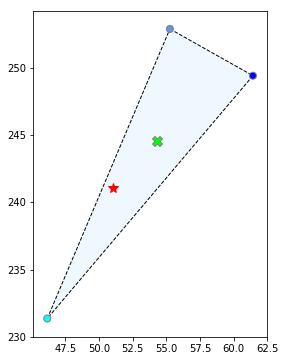

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.757753129897827 0.2665796643771827 8.753694943666687


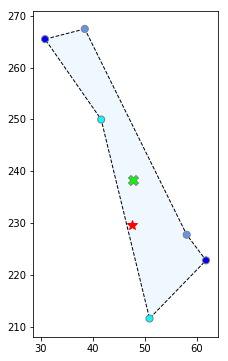

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.857127576901119 -3.8188703192377247 -0.5419064765586938


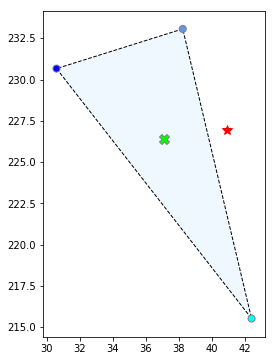

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.1832173873904996 1.6706382948284855 -2.7095831087526676


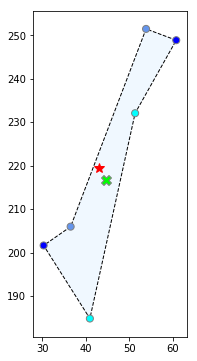

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.21983983549328 4.939095170656628 1.6888063250115124


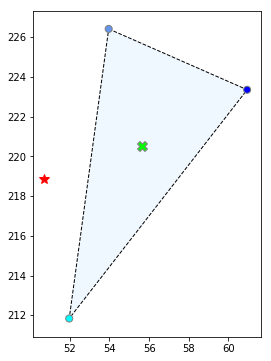

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  0.5201832533616638 -0.5194634330355541 -0.027356147697389588


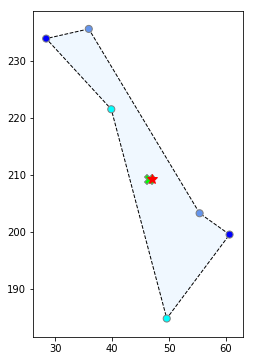

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.21195807380962 -4.6202469387154395 2.4120168300490548


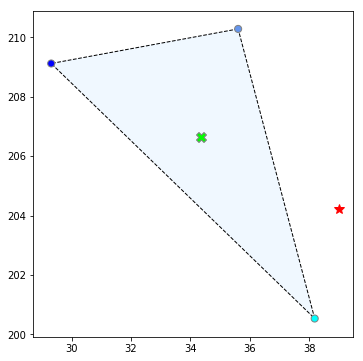

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.028915980194502 0.7014032729915698 2.946585390535006


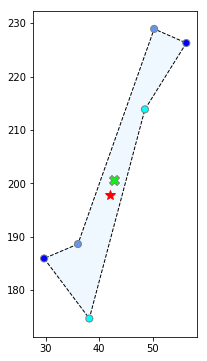

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.831276746747519 4.57897652689558 1.540846835283304


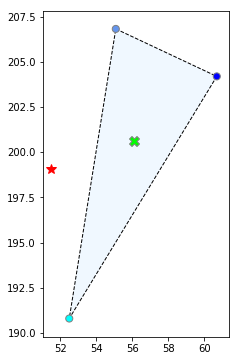

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.717856325141585 -0.007126517417553657 6.717852545121417


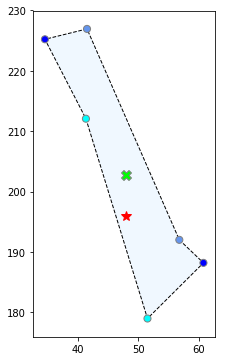

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  2.7393855041771342 -2.2261369456419047 -1.5964170005809706


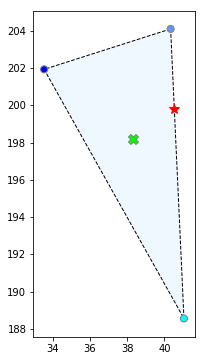

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.9770867649333677 1.5521070362285414 3.6617185697289756


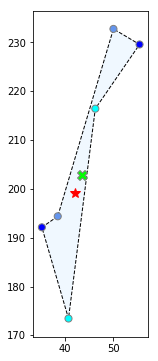

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.266286214782158 0.39949500678255134 -7.2552959343288705


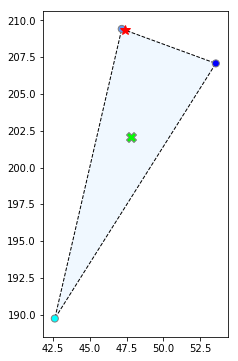

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.508320389290832 -1.5106372109694988 4.247696781707674


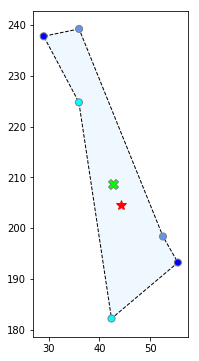

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.045033177926326 -5.636657396939135 -2.184151897593523


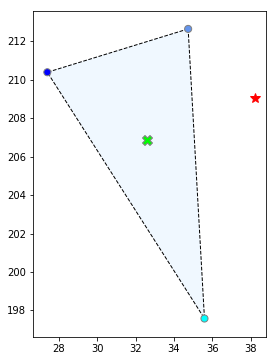

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.5036277943158587 2.2932367967047753 2.6488625323602264


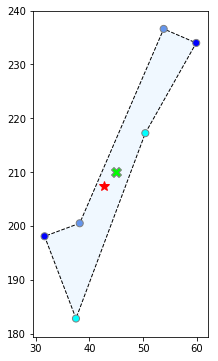

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.08572115920107 5.039753442287449 -4.980796079634416


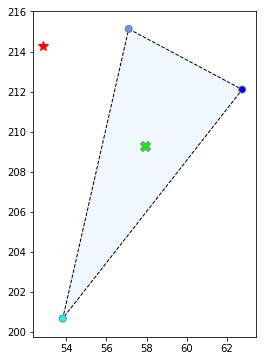

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.712767360681679 -0.20787409796115952 6.709547972705025


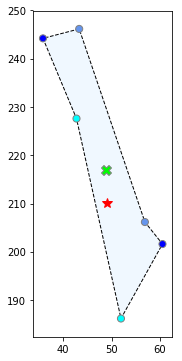

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.0320242159884088 0.08592392732398935 -1.0284410829501667


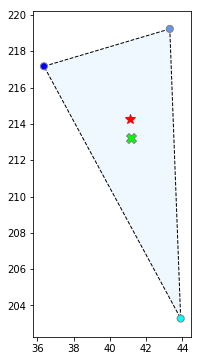

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  2.289095459633254 2.0818237389878007 -0.95182348316294


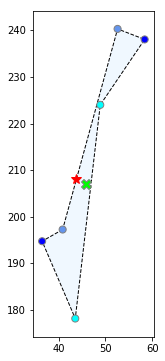

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.372622432633411 3.775764661456897 -2.205318153841347


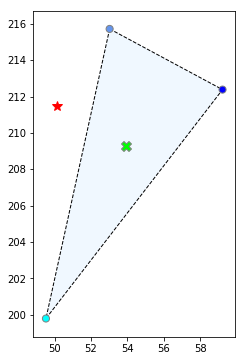

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.4917358265869318 -0.8610959743691922 1.2181089849632372


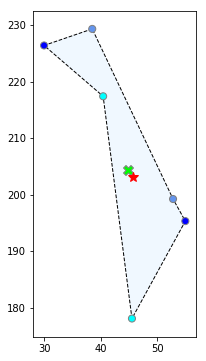

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.537182257864088 -4.171413104776825 -1.7847508370562082


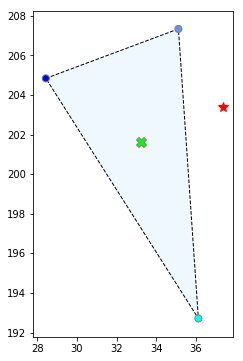

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.058274539579182 -1.577754176009563 -3.7390217970320805


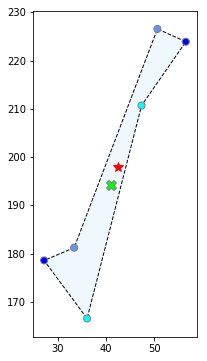

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.8867661238823406 4.044821445007997 -2.742244086059344


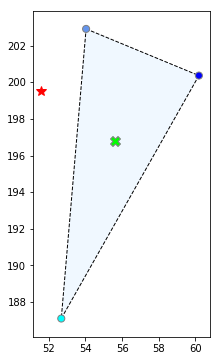

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.104549816818814 -1.5074355204613497 4.87689111873911


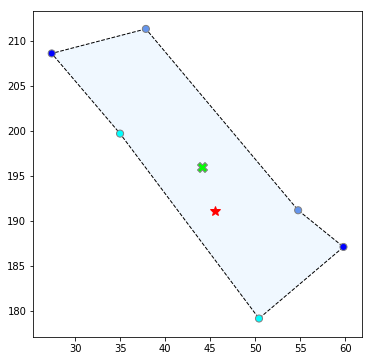

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.006768754135617 -3.663646531747041 -7.119412895219682


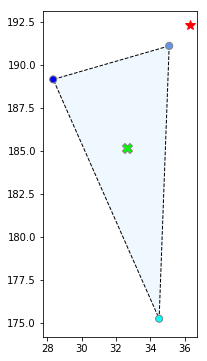

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.089872241460911 1.345392138909844 7.977214606347218


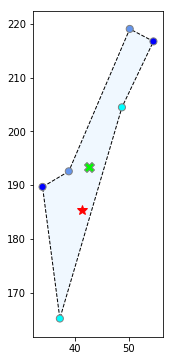

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.6143076334621034 0.9142504691090707 -3.496765040581977


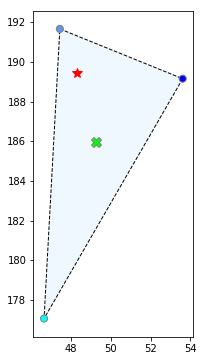

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.620141332519031 -3.1164629243392596 12.229293769223716


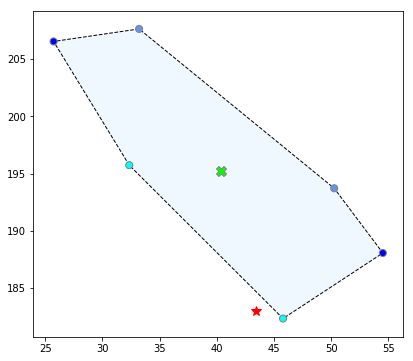

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.686952710869313 -4.489740019058061 -3.4905108074510167


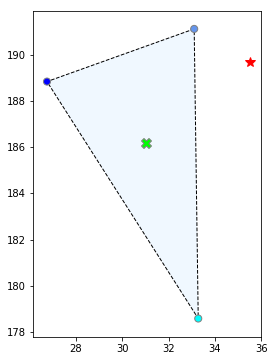

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.600803065652668 2.6898264854528193 9.216303650792014


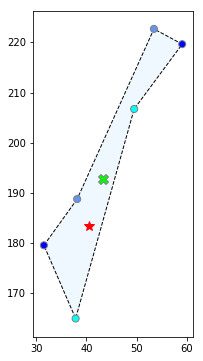

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.5081635270352445 3.3145447376784176 3.055704758058141


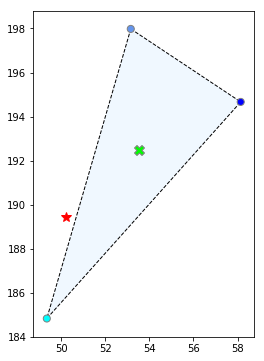

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.012829063932705 -1.401653422834336 5.84717718513221


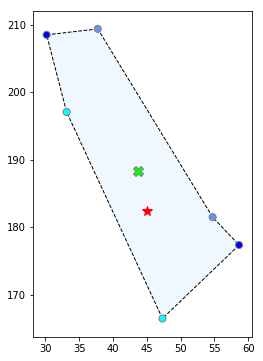

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  0.8736451465382585 -0.7691163993029377 -0.41438605960280483


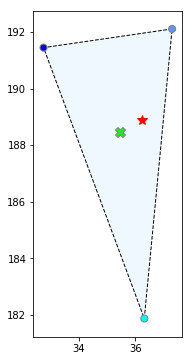

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.7394468728575 1.6504438336417664 5.497025155331528


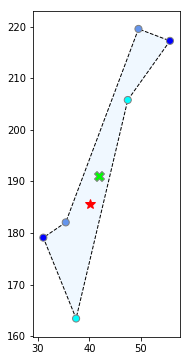

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.516038597569474 2.1717730228440857 2.7651273672011882


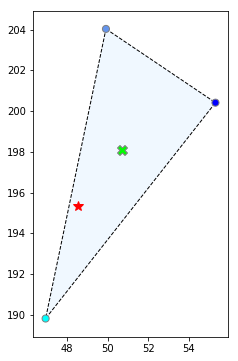

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.592608477406729 -0.6442295685331914 5.555379180991082


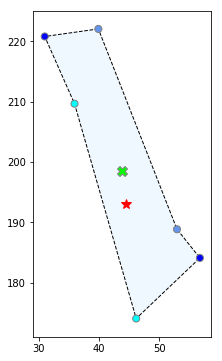

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.502910408364876 -2.9504333801776 -9.033285620334567


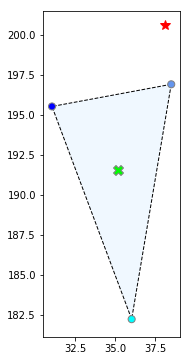

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.453712411923685 -0.701050950647776 -7.42067087831424


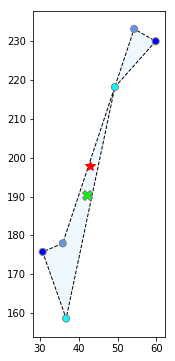

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.2242694511999686 4.224268671532727 0.002566524578952567


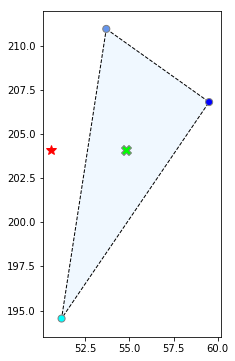

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  10.990245001766741 -1.0302586188315885 10.941848672741827


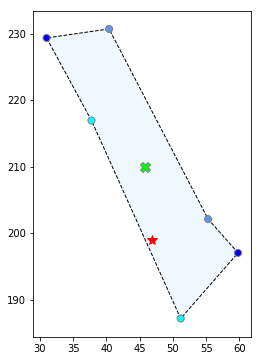

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.600869934781237 -1.7975939869641948 1.8796755772417555


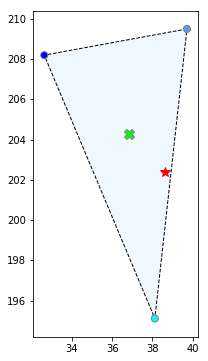

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.025775386055303 -0.2118955323854479 -5.021306454941225


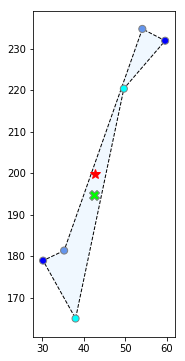

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.480298842465949 6.18560058397545 5.8011907288979785


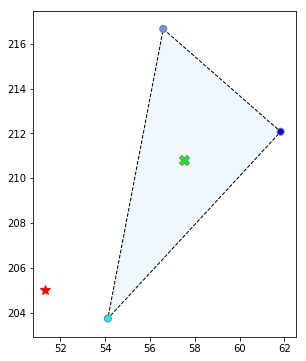

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.456919428060324 -0.05881372153039166 8.456714915312205


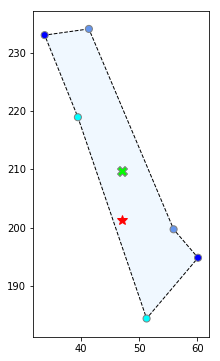

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.076990283278589 -1.2548016005841092 -3.8790878712810297


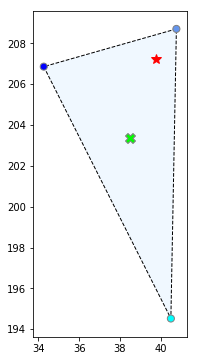

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.344622791228779 2.182564503013495 -0.8565443498937384


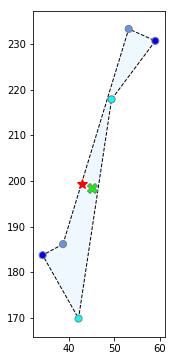

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.9560496502669285 4.958176752915477 4.878843103013992


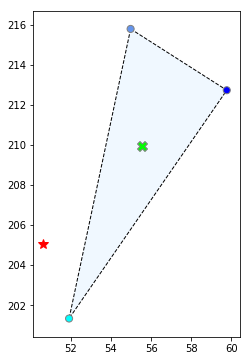

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.8939124547095565 -0.3842001432990543 5.88137690287482


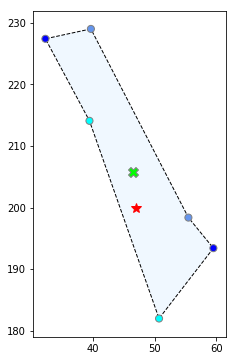

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.6627802371253817 -1.7133975592445267 -3.237318005610689


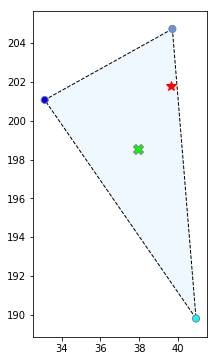

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.868367352351691 4.039070636172809 5.555211830601706


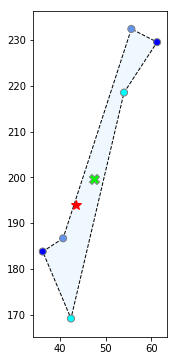

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.921568353322237 4.0186357178299374 -2.841197287026091


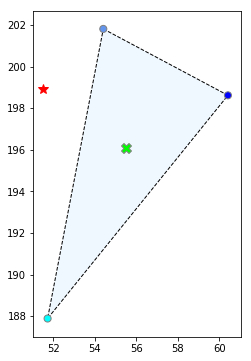

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.8930646898154686 -1.9509065373077732 2.136302174821452


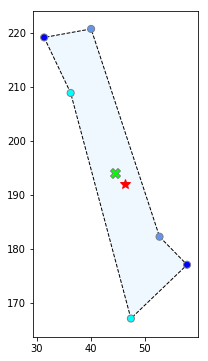

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.299218257658057 -4.062247168177407 -6.064382500928133


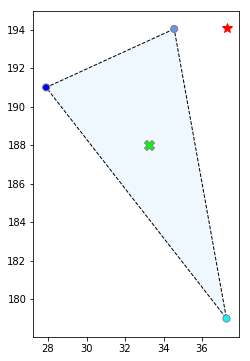

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.1209059715610525 2.3440364421674715 4.552929949753292


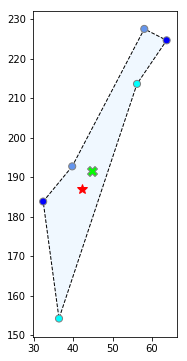

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.375540901724184 4.38282389257256 3.1124419211938346


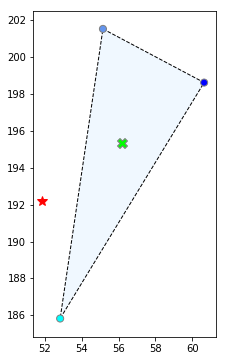

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.8578893421074163 0.39285954036223103 1.8158783519450594


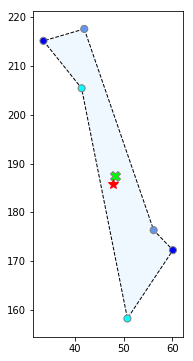

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.5771563623673888 -1.2602773732337482 0.9482210363997297


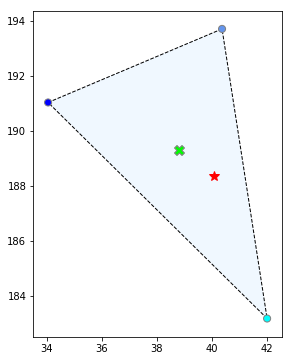

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.570515803749752 3.873401581837129 8.751658867645915


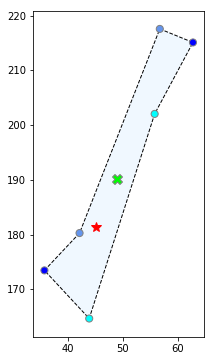

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.717625331347403 4.215276242862288 -2.1183566657509516


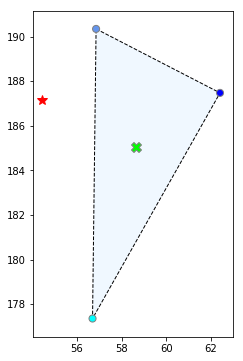

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.734272886477053 -0.7038993738919856 4.681651998500769


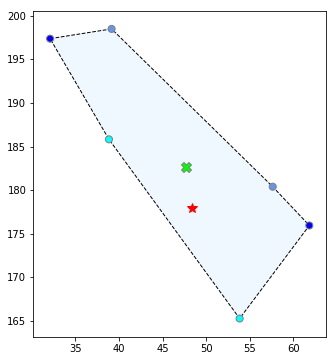

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.854292327366159 -3.170717807202408 -4.921309504730203


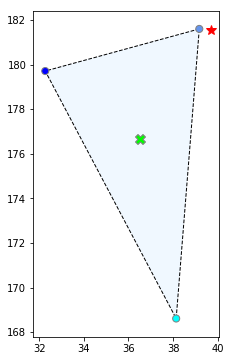

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.6802267080522901 -1.1102246037882253 -1.2611752929690283


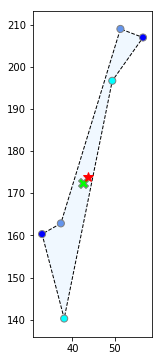

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.043786393182237 3.9718993538299046 0.759094142205953


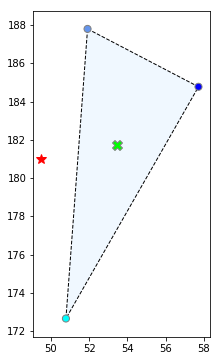

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.671441370108594 -4.487590667610945 6.221940428434266


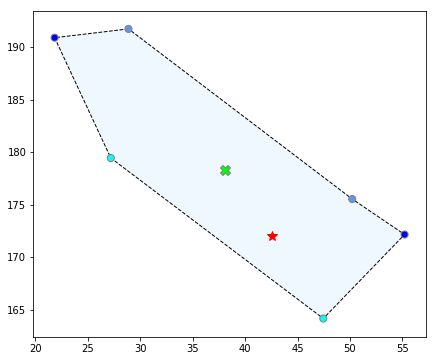

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.619957054290655 -5.34155791921274 -6.765457753434788


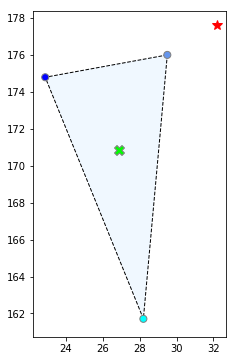

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.872721451488651 -2.763996207105464 8.43122238603712


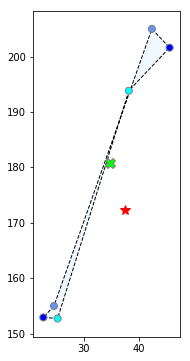

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.00185084894919 0.041992546872755554 7.001724925826323


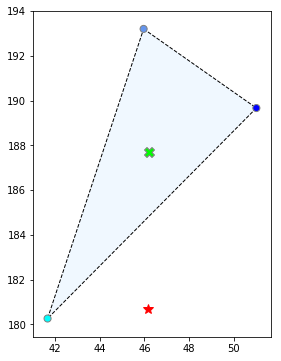

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  10.681264855228669 -0.981205009177593 10.636101524407707


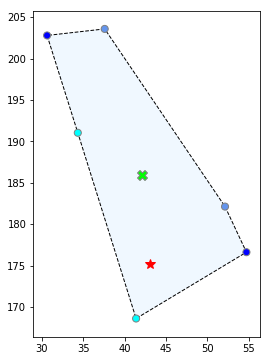

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.806593265448262 -3.141587627570445 -6.038223170730106


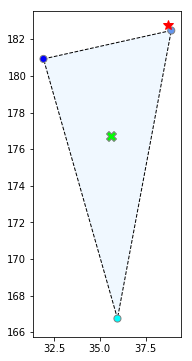

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.2030969781654495 1.7457964288443293 5.952361459921576


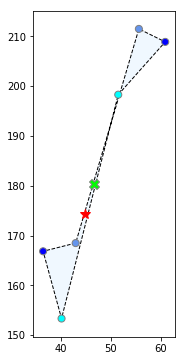

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.127881342417547 5.168249008873296 8.70994734016054


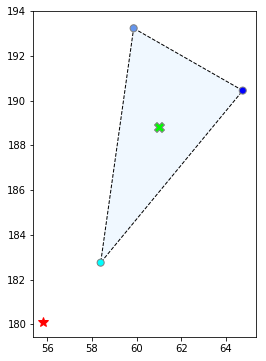

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  11.386544421433484 2.035997159107417 11.203040186903934


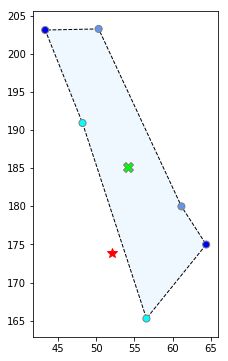

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.5737552985077943 2.962060379421999 1.999481243290603


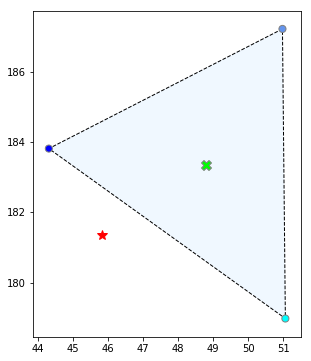

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.1059677408534614 3.0666893601981826 0.492394125949545


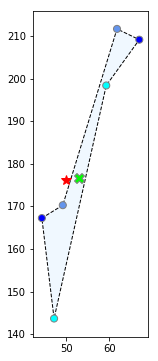

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.742514078614442 5.715989705764251 -0.5512981286764784


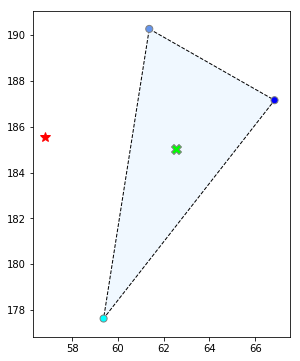

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.063622114713431 1.5918328579234142 1.3132419368759543


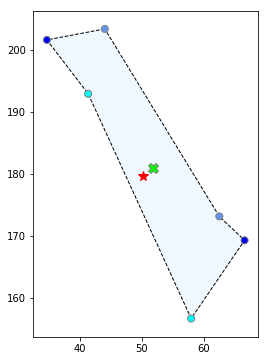

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.22128809775796 -1.6755436565778652 -9.067784053270913


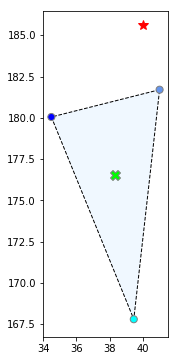

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.7137721067266725 -1.0948140781660385 -6.623905044255281


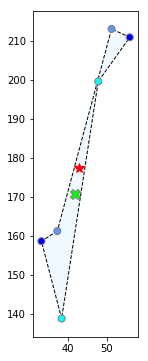

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  2.017616421307453 2.0135064893291528 0.12871534857538336


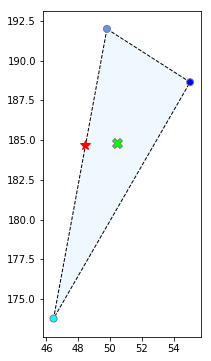

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.966300472102006 -2.105961012444773 8.715473158129697


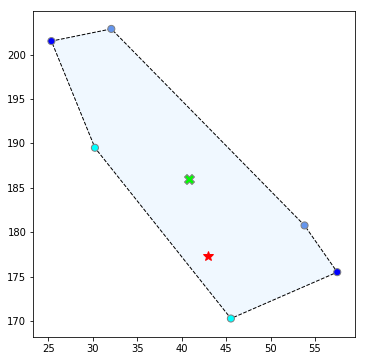

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.971314500972269 -5.317588846882565 -5.9384428707297445


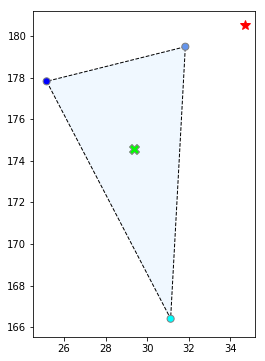

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.128582637685566 1.144486569657282 10.063713864190476


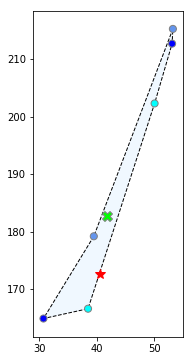

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.935777685790945 0.872892975051009 5.871244722308916


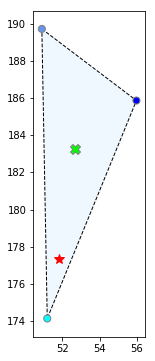

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.041378467492077 -0.1881237185813589 7.038864978742538


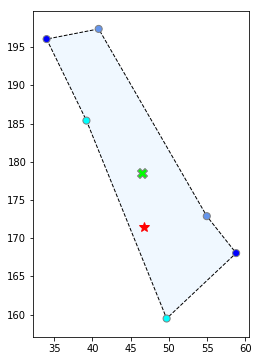

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.997536920796302 -2.3020629224626745 -4.4357503960147255


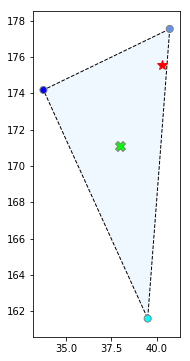

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.9784099856809 2.7295501858246 8.553443847599596


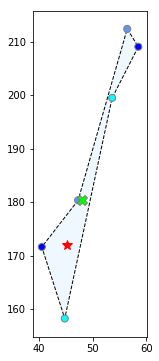

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.008320022110327 3.8708745270709244 5.84233514341534


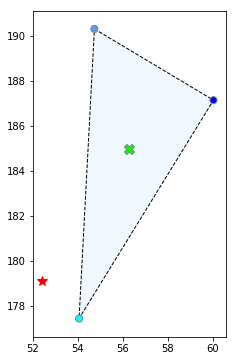

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.978498723777223 -1.2895226205563546 7.873599767348367


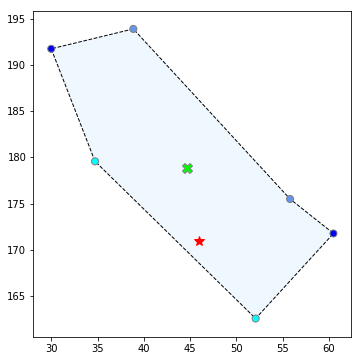

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.180518632168864 -2.9614801105409825 -6.541367088139481


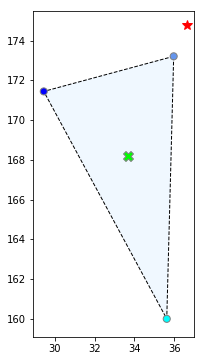

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  2.186839441534212 -1.8217012820215288 1.2098227895567106


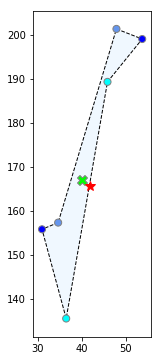

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.180817319615155 2.309379338906645 7.8480914295098785


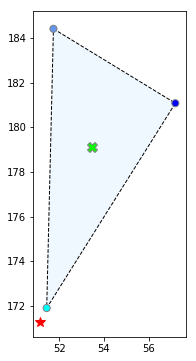

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.88887285530536 -1.4788031510080444 9.777675980976454


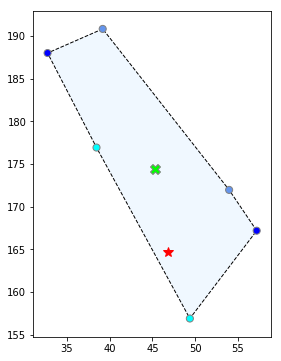

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.066876179864555 -2.9609858105512075 -4.111665994678219


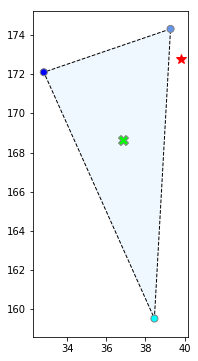

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.362482012699011 -1.5107857056976002 -3.003966017980929


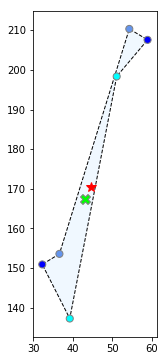

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.535241254092263 4.797772654316276 7.059158648383914


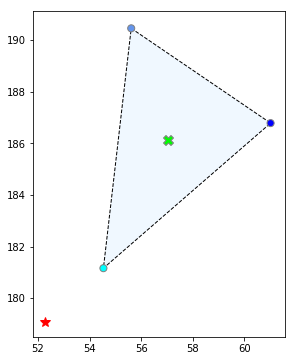

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.671936357163745 0.02753300920190327 3.671833131348052


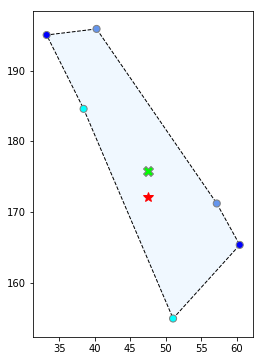

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.9663843737107705 -2.888987179486378 -5.220296502271054


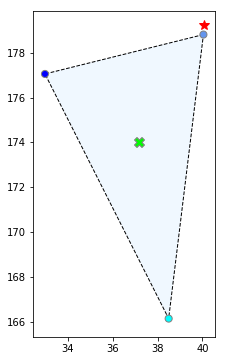

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.7169396311786596 1.8971797756865243 7.480098005372781


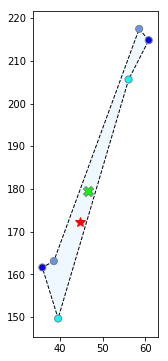

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.373600490530278 4.039936398887896 1.6754984761877267


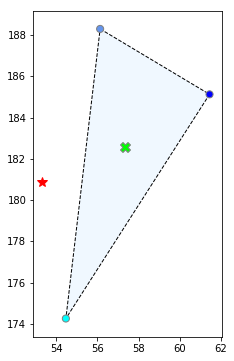

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.139317792292406 2.010917353124327 9.937906051679136


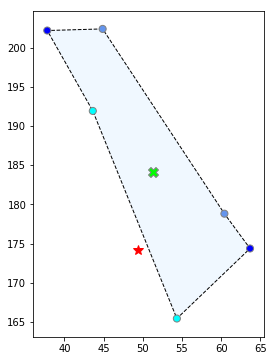

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.115703108878151 -1.1490688629352732 -4.98498335467815


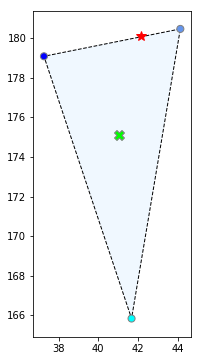

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  12.864178181688064 3.391523781121272 12.40905502978805


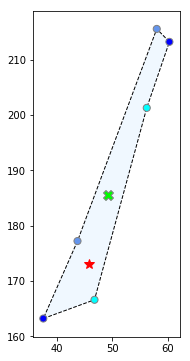

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.929263336654143 5.796183155587038 11.557253620797553


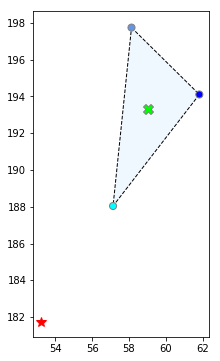

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.465727669888748 -1.130522656643059 10.404488174970055


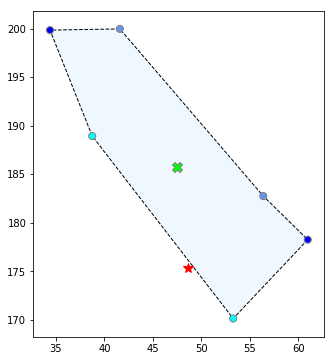

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.6588282337462714 -1.3803156307309123 -3.3884735211624104


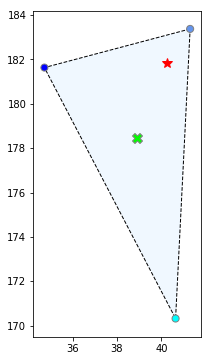

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  21.841573296317826 7.493622698205655 20.515846141832924


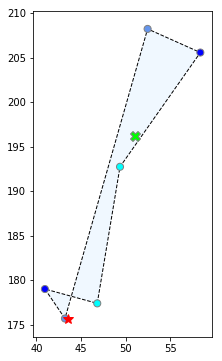

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.099700613604303 3.7240377480782954 1.714376846575874


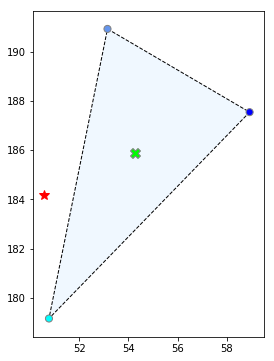

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  10.727098432992307 -1.0567817597344344 10.67491700686233


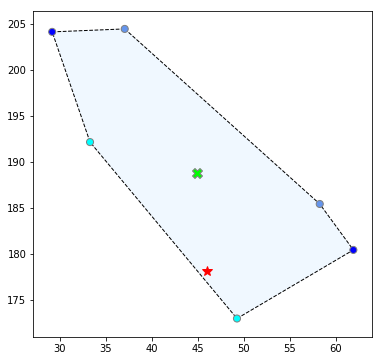

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  2.914913035069818 -2.5682111332012454 1.3787710387591972


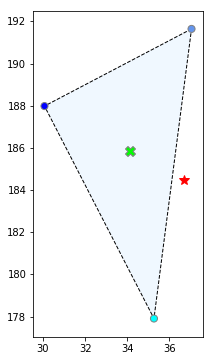

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.2378965132800848 0.06012063026340542 3.237338311101894


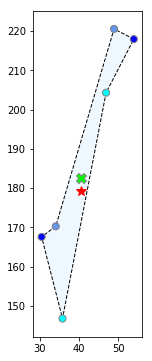

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.09152552069757 3.090272445480231 7.478168322845221


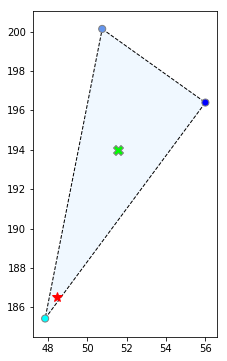

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.748719080751699 0.3136822657008054 7.742367262574817


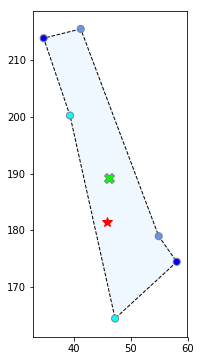

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.168228678378135 -3.2420211878662855 -8.57587988001589


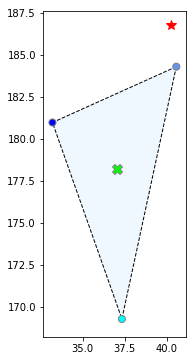

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  10.699005948824567 -2.2523128220615547 -10.459245443365432


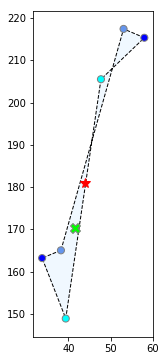

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.6035161813597147 3.274736094560673 1.5038059649778006


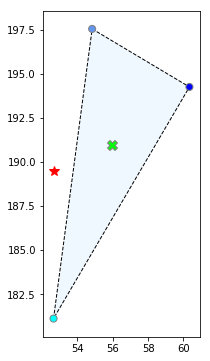

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  14.251853548240284 0.23970770289037802 14.249837535132258


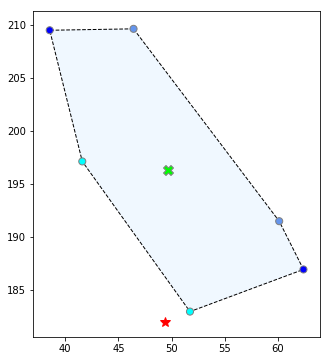

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.287072024207304 -1.0997503090811378 -6.190139246838157


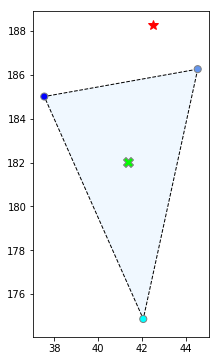

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  13.239103094370737 5.223057135890663 12.16525893265731


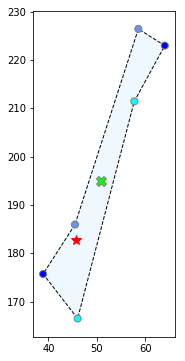

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.7654022901905053 3.629978678958132 -1.0007543141457234


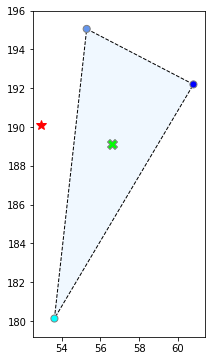

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.756643346173874 -1.4092470734167222 12.67856348911613


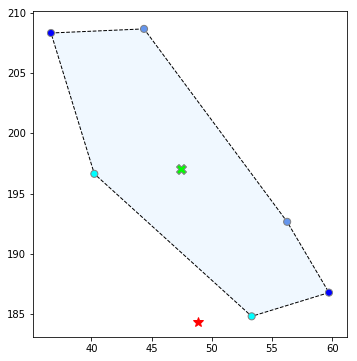

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.2773478581225843 -0.7967641250646054 -2.1334198358282777


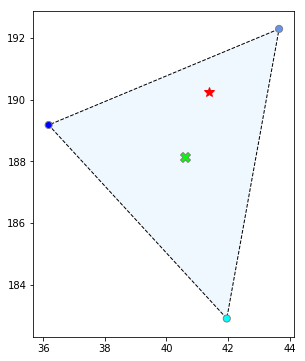

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.534715451651316 4.1857719135587885 8.566802917752966


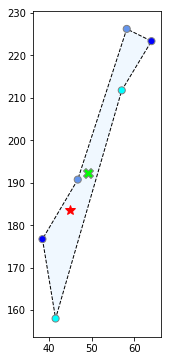

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.9169397114261075 4.850669893062822 4.931029969492926


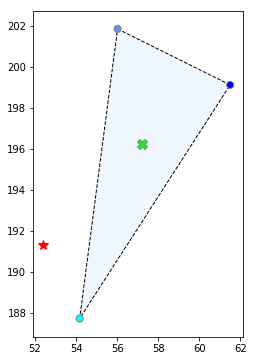

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.29823220830945 -0.4891839295940841 10.286607103379083


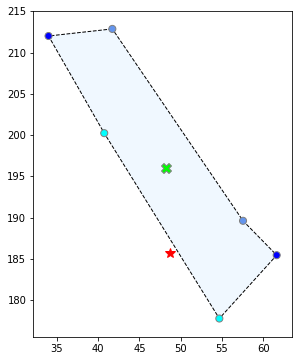

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.728361169806742 -2.0788739879839895 -3.0949894918410052


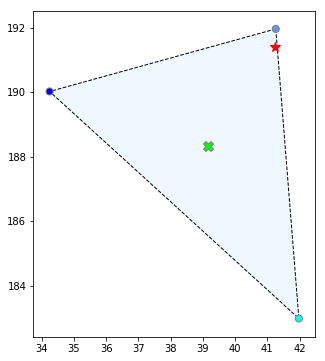

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  11.813408235027936 5.651717940924065 10.373750452158703


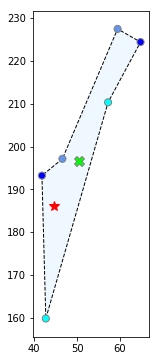

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.337240324164337 4.364477010130905 5.898002713002256


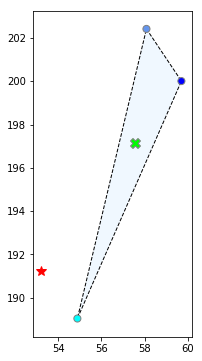

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.507770672851654 1.0784787755962668 9.446406020181769


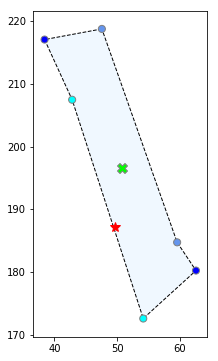

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.7989216695325971 -0.12187326150385758 -1.7947885895682418


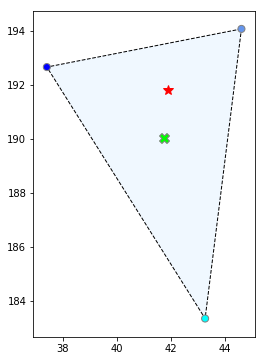

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  16.367649595687954 5.762393451306465 15.319751140262184


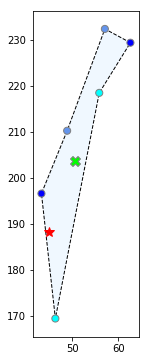

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.1481468804069035 3.69865132504777 -1.8780577512823982


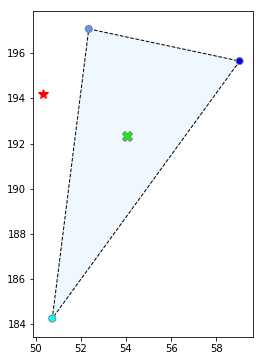

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.144589117450423 -2.0327824211146392 8.91578968770574


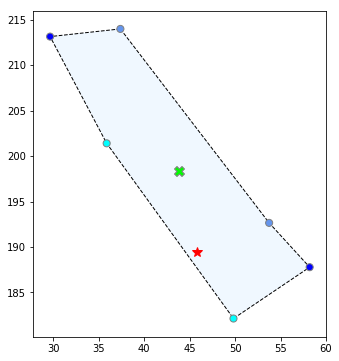

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.686423739242356 -3.1006056383490233 -9.176766834326571


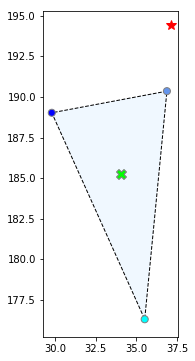

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.8720280571895414 -1.2233466654109435 -2.5984549442912908


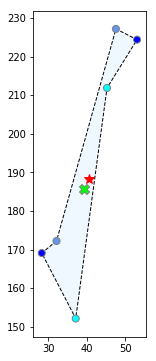

right SS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.1541241682837056 1.398527704014434 1.6384050761298568


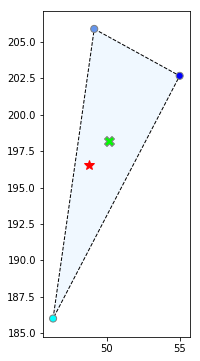

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.881442769341655 -0.8211018723509653 12.855246381732485


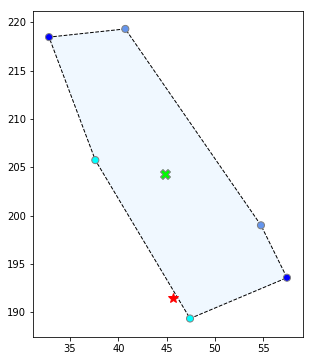

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.564521509122878 -3.002716991815106 -8.020892677706968


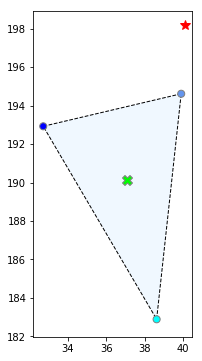

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.8958720935731512 0.5570628119578487 -3.8558397779233076


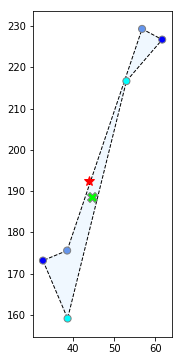

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.9417080217551863 3.9314695340598007 -0.2839180014173053


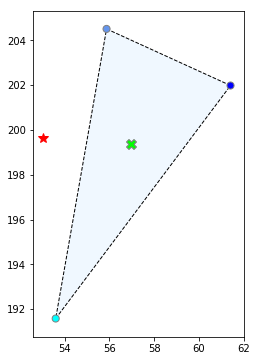

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.4293500568018835 0.8973977402609634 7.374952173558597


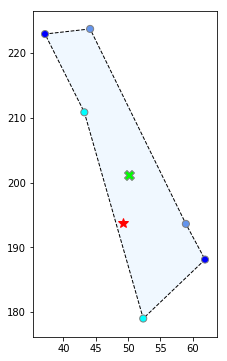

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.980898707785871 -0.15016507478893004 -1.9751987598268101


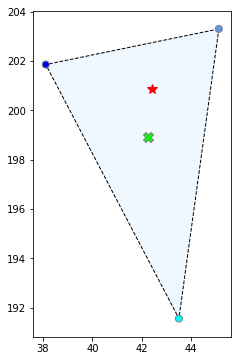

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.3763514861227626 2.270055251953366 2.4993196095982455


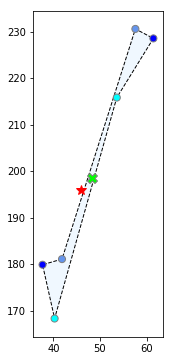

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.891573872287304 5.033072550819867 4.707650277513892


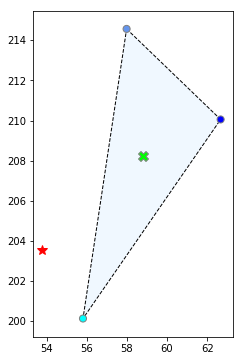

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.235180180764808 1.7893312276747295 4.919898909809092


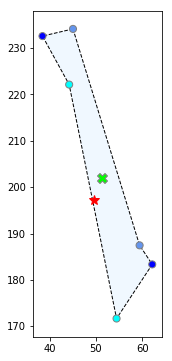

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.441756510240934 -1.5279408473275709 -9.317304479609163


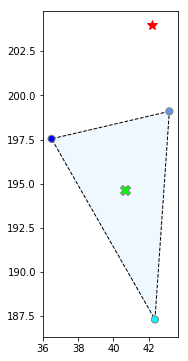

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.705182208374952 1.5546911043344807 -4.440909274474251


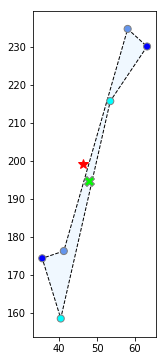

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.521024571823233 5.500817468805735 -0.4719316661949904


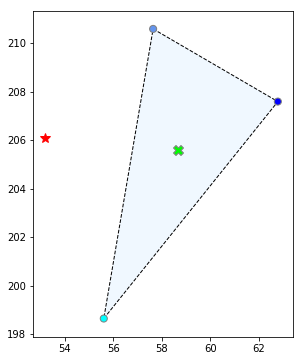

terminal DS False
Euclidean, Lateral and AP distance from centroid (in cm):  15.331904626363604 -0.012749493589858218 15.331899325338753


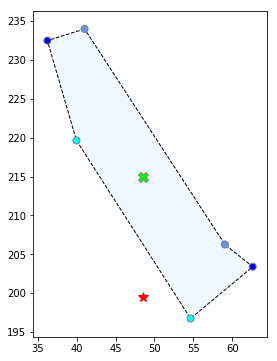

left SS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.3343641674347717 -0.7901573214034485 -2.1965672021670457


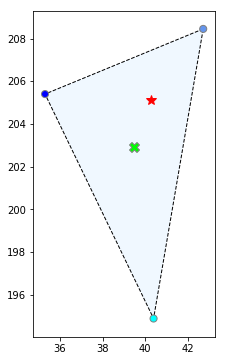

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.511241856697684 0.8712301775073854 -3.401437542279183


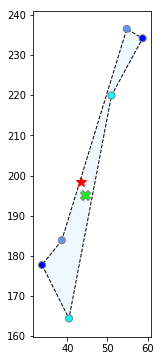

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.614613627268694 3.5163339334789825 -2.9883196946173882


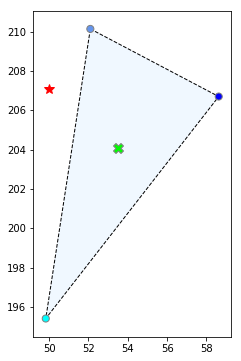

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.841660263667678 -1.471799244822975 2.430810572020448


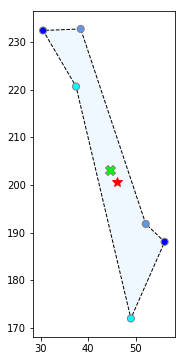

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.63318672594065 -2.2518263465366672 -9.366299408084416


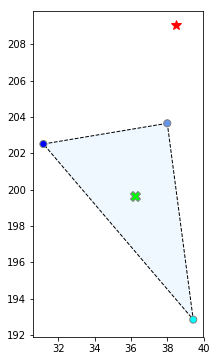

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.2730358203273755 0.4794031482104515 -2.221905592498757


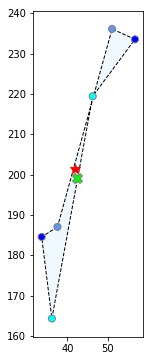

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.7193771691667346 2.80242705845108 -3.7972257566430585


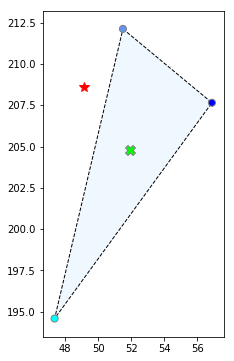

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.470438667550697 -0.7522730831358544 6.426559091685419


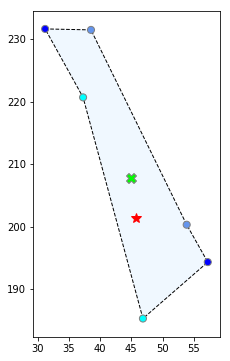

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  3.8573692608275114 -2.5996243213265515 -2.849780869180023


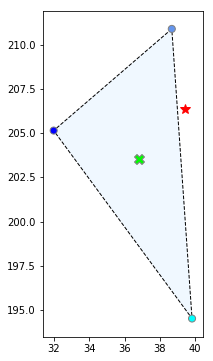

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.4640065371625335 0.8052516332208413 -6.41365342996292


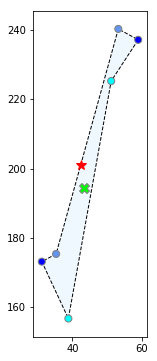

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.6661487500189 4.663193380563008 0.16604714022315648


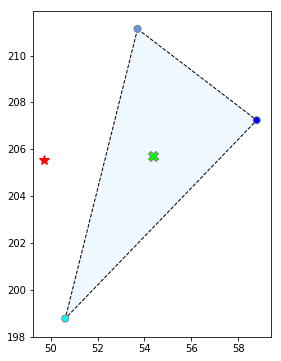

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.422704519977688 0.7867277236653365 6.374338619790933


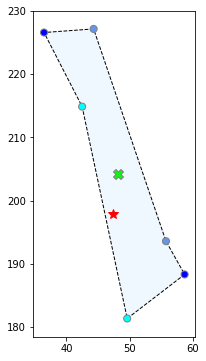

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.689802037960342 -0.5847868081752097 -6.664193551817249


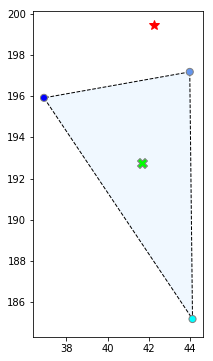

initial DS False
Euclidean, Lateral and AP distance from centroid (in cm):  8.84160115037206 1.0962630254755439 -8.773375535176626


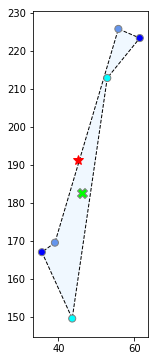

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.46125977675844 3.677974108202669 -4.0370614075872595


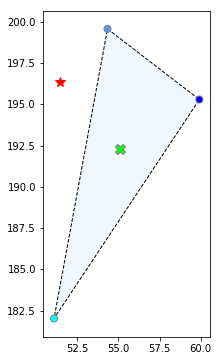

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.163263929292703 0.07850764095065443 5.162667038832495


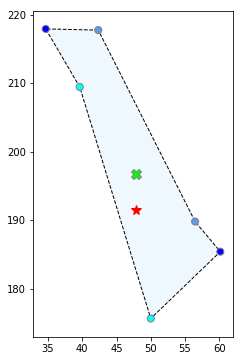

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.120543504082658 -2.6159308185915364 -9.776620416604743


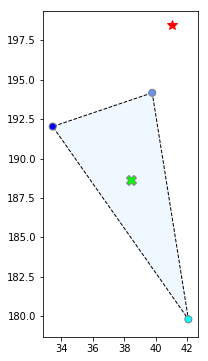

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  11.574363430779107 -0.08743460780731738 -11.574033178504123


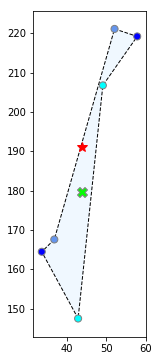

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  7.124839105215338 3.0888891803508614 -6.4204435911171345


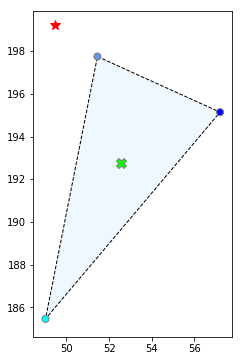

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.4505275689962043 -1.4087792220921642 -0.34550156558174194


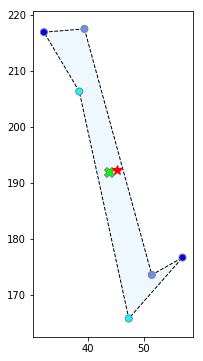

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  13.182147739130192 -2.8866129810478114 -12.86221149390343


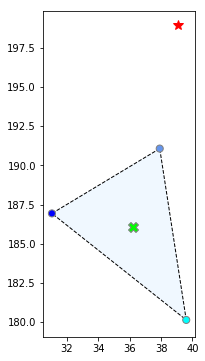

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  5.898496467273298 3.1557255699037654 4.983337907656988


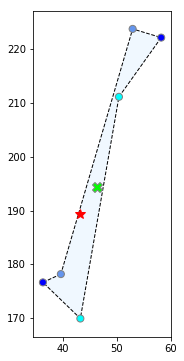

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.591180964935252 3.0219908541046863 -3.4563729443582076


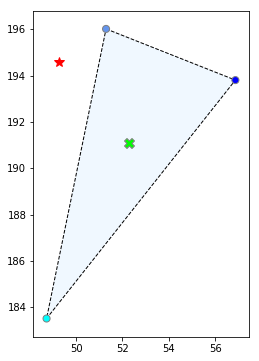

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.495180023620143 0.03774251085035729 -4.495021573655492


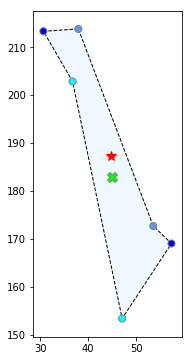

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.6926868521655 -3.049900253655082 -9.200341670660748


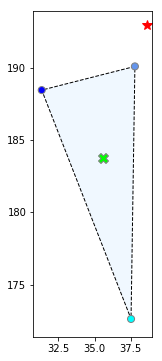

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.581623826602573 0.7019948117818231 -4.5275247291123435


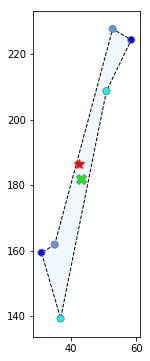

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.714606019400786 4.2534821778223275 -3.816361004925966


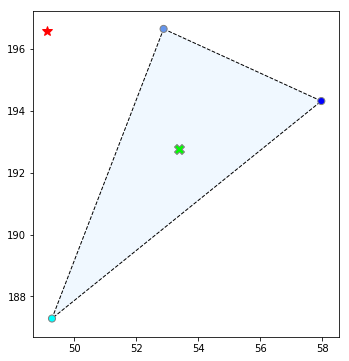

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.0188124091120234 -0.4155957620983912 -0.9301929302496887


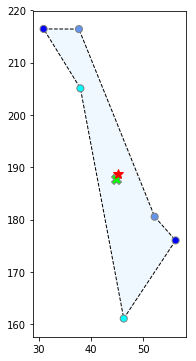

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.035515749532484 -3.459541159432831 -11.527584930219973


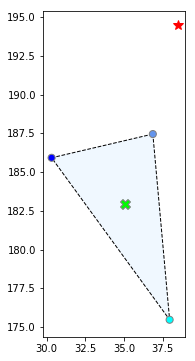

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.670306770454141 -0.8912370330180366 -4.58448054648801


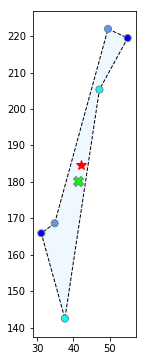

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.182707297211065 1.7785450974485855 -4.867980306544638


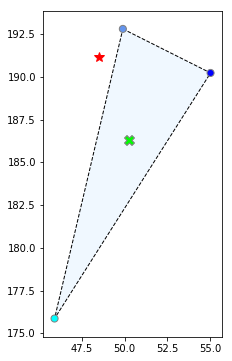

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.445285460784933 -1.3582902042811327 3.166234297592325


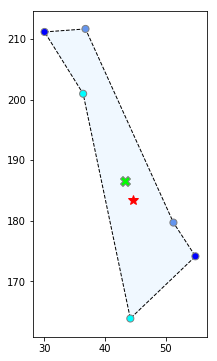

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  10.312679482023812 -3.2367535831454006 -9.791567001300166


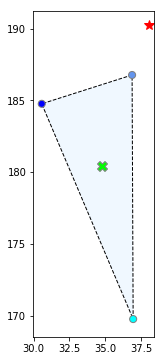

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  9.88093211491688 -1.2260265837040407 -9.8045743546391


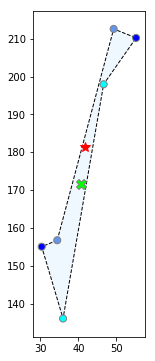

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.077169386168464 1.844157678387191 -8.887861751987344


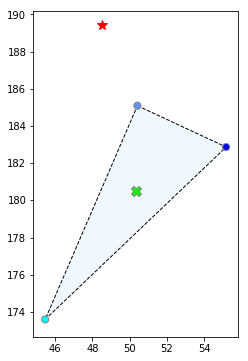

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.050900817581767 -1.7228515166630771 -2.5178916676959773


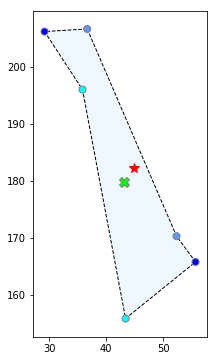

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.928033504322832 -2.3498985744420864 -4.331684534862092


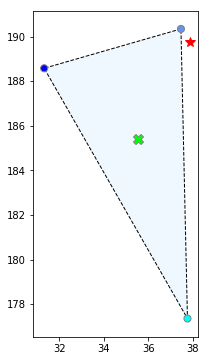

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  7.276092677095445 -0.8695554129353624 -7.223946153558785


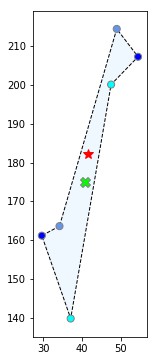

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.815375842732719 1.5773103524171432 -5.597382267131394


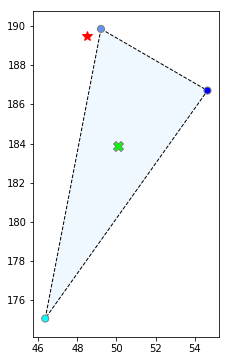

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.340244839732493 -0.42959386264724486 1.269529575711175


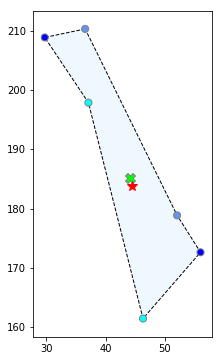

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  14.658059215659929 -3.9308633481578212 -14.121154814954139


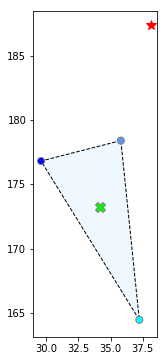

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  1.7803042209148743 -0.5608516240856858 -1.6896533889433556


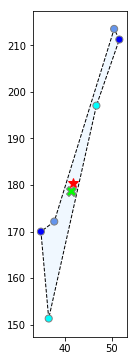

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.4990374960534005 0.9590724477310104 -6.4278821096152114


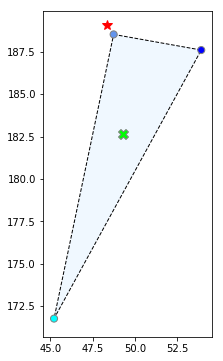

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  3.5978543627447968 -0.5497320191779593 3.555608347753207


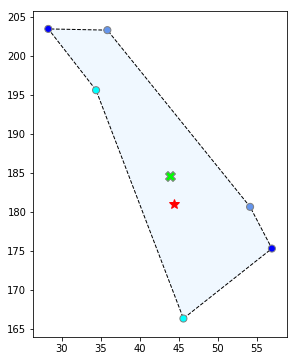

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  9.264564468159794 -4.159389405482365 -8.27838357158268


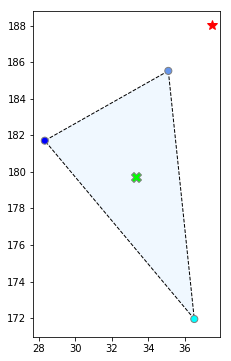

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  4.548706081349823 0.4895289561532934 4.522287962480533


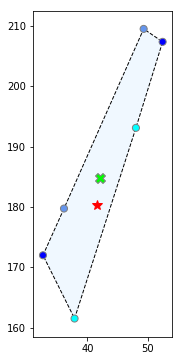

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.528201829445688 2.1098553273176535 -4.006634785700413


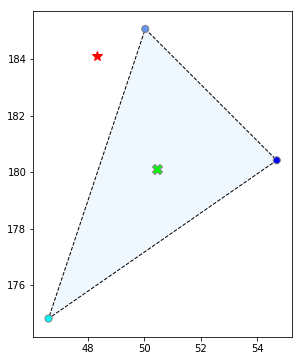

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  8.161660066423847 -0.3268195201339168 -8.155113980878326


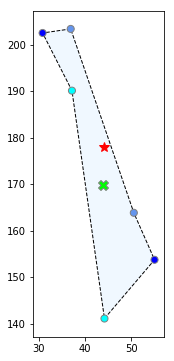

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  12.351383660966388 -3.606267412893338 -11.813192357999213


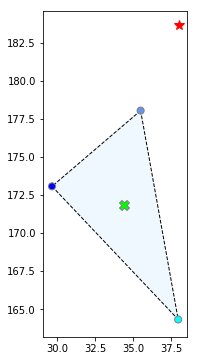

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  6.89378288932157 -1.3243084211170952 -6.765386147949073


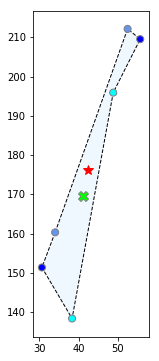

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  4.875602693256961 1.3370895134571725 -4.688677132784619


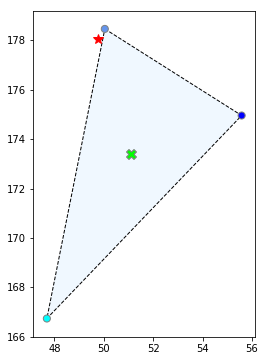

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  2.180636142575346 -1.257329497323667 -1.7816555563479994


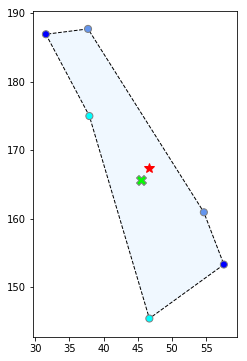

left SS False
Euclidean, Lateral and AP distance from centroid (in cm):  6.672877273441527 -3.028613484652098 -5.945989527992452


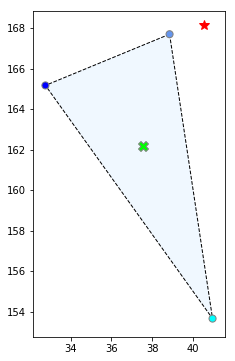

initial DS True
Euclidean, Lateral and AP distance from centroid (in cm):  0.8005416877154662 -0.25822195741680787 -0.7577522117936439


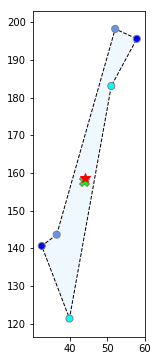

right SS False
Euclidean, Lateral and AP distance from centroid (in cm):  5.17879544566595 3.0017522820217337 4.220119134032558


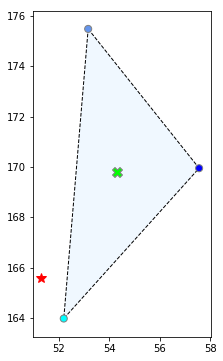

terminal DS True
Euclidean, Lateral and AP distance from centroid (in cm):  0.9972225513909507 -0.9822225906623316 0.17231250504607942


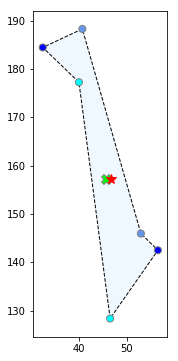

No. of CoPs lying inside polygons are: 105  out of  207
Average euclidean, lateral and AP distance from centroid in cm:  6.279722129601424 0.38951816825308605 0.6381626908270426
Standard deviation in euclidean, lateral and AP distance from centroid in cm:  3.4113919896414484 2.745886509415986 6.555428024625099
Average absolute lateral and AP distance from centroid in cm:  2.262509966722923 5.459626831784539
Standard deviation of absolute lateral and AP distance from centroid in cm:  1.6039531715331918 3.68420453607859


In [98]:
plot_frame_wise(viz_file_grouped, video, non_normalized = True)

In [100]:
viz_file[coordinate_cols_x]= viz_file[coordinate_cols_x]+9.2
viz_file[coordinate_cols_y]= viz_file[coordinate_cols_y]+1.8

left toe 1-x      28.006
left toe 2-x     21.7747
left heel-x      27.1295
right heel-x     37.0688
right toe 2-x    48.8634
right toe 1-x    42.7694
left toe 1-x      28.006
Name: 4, dtype: object left toe 1-y      231.52
left toe 2-y     229.107
left heel-y      207.094
right heel-y     254.218
right toe 2-y    273.642
right toe 1-y    274.843
left toe 1-y      231.52
Name: 4, dtype: object
43.90015626926846 242.5276023589361


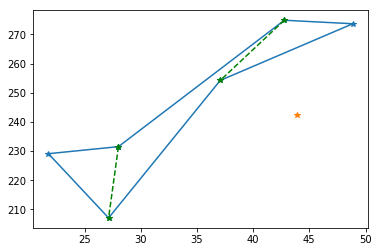

In [476]:
i = 4
print (viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y])
plt.figure()
plt.plot(viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y], '*-')
print (viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'])
plt.plot(viz_file.iloc[i][both_foot_single_join_left_x], viz_file.iloc[i][both_foot_single_join_left_y], '*--', color = 'g')
plt.plot(viz_file.iloc[i][both_foot_single_join_right_x], viz_file.iloc[i][both_foot_single_join_right_y], '*--', color = 'g')
plt.plot(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], '*')
plt.show()

In [36]:
poly_xy = [(x, y) for x, y in zip(viz_file.iloc[i][both_foot_coordinates_x], viz_file.iloc[i][both_foot_coordinates_y])]

In [37]:
is_point_in_path(viz_file.iloc[i]['treadmill_COP_x'], viz_file.iloc[i]['treadmill_COP_y'], poly_xy)

False

In [437]:
p = asPolygon(poly_xy)
p1 = p.centroid

In [442]:
p1.xy

(array('d', [32.85276633924384]), array('d', [239.985046366188]))

array([43.90015626926846, 242.5276023589361], dtype=object)

In [445]:
np.array(p1)

array([ 32.85276634, 239.98504637])

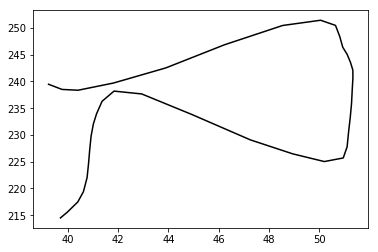

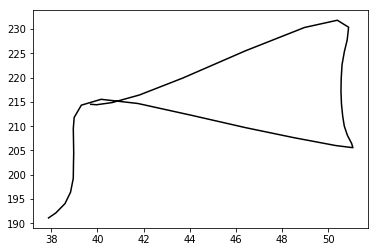

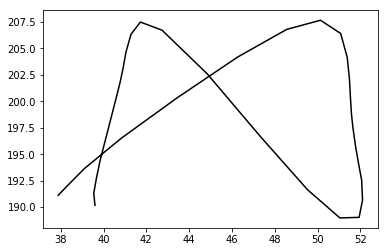

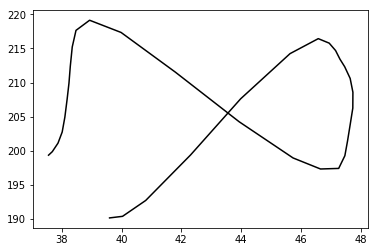

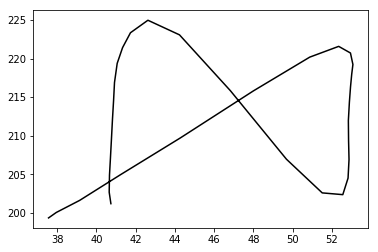

In [353]:
for i in range(5):
    limits = range(viz_file[viz_file.EventType=='HSR'].index[i], viz_file[viz_file.EventType=='HSR'].index[i+1]+1)
    plt.plot(viz_file.iloc[limits]['treadmill_COP_x'], viz_file.iloc[limits]['treadmill_COP_y'], 'k-')
    plt.show()

In [98]:
viz_file[viz_file.EventType=='HSR'].index

Int64Index([   0,   37,   73,  108,  141,  174,  207,  239,  271,  302,  334,
             364,  395,  426,  456,  485,  515,  545,  575,  605,  635,  665,
             695,  726,  756,  785,  815,  845,  874,  904,  933,  962,  991,
            1021, 1050, 1078, 1107, 1136, 1165, 1193, 1222, 1250, 1278, 1304,
            1331, 1358, 1385, 1412, 1440, 1468, 1495, 1523],
           dtype='int64')

In [431]:
len(viz_file)

1530

In [99]:
viz_file[viz_file[viz_file.EventType=='HSR'].index[0]:viz_file[viz_file.EventType=='HSR'].index[1]]

,frame_number,Time,EventType,support_type,left toe 1-x,left toe 1-y,left toe 1-conf,left toe 2-x,left toe 2-y,left toe 2-conf,...,right toe 1-y,right toe 1-conf,right toe 2-x,right toe 2-y,right toe 2-conf,right heel-x,right heel-y,right heel-conf,treadmill_COP_x,treadmill_COP_y
0,174,8.798660,HSR,initial DS,28.338049,240.532593,0.695041,20.390447,238.138611,0.705139,...,276.702275,0.619260,50.842480,276.496314,0.613129,39.630913,261.955583,0.509070,39.239220,239.472853
1,175,8.831517,NaN,initial DS,26.475230,238.034313,0.696155,20.254670,235.571413,0.703538,...,276.906947,0.619896,49.931840,275.985777,0.622999,38.863616,260.998522,0.502501,39.775586,238.506069
2,176,8.864374,NaN,initial DS,26.476401,238.032542,0.690571,20.257819,235.573091,0.697692,...,276.694999,0.630604,49.856279,275.868226,0.631578,38.426218,260.991312,0.510657,40.411265,238.355536
3,177,8.897231,NaN,initial DS,28.052194,232.813207,0.678782,20.951137,230.405488,0.707192,...,277.840082,0.595470,49.188310,276.472850,0.597099,38.054712,258.688896,0.447133,41.817108,239.698474
4,178,8.930089,NaN,initial DS,28.006002,231.520070,0.616343,21.774726,229.107303,0.619540,...,274.843349,0.606450,48.863396,273.642274,0.609355,37.068784,254.217909,0.466853,43.900156,242.527602
5,179,8.962946,NaN,initial DS,27.837073,226.419826,0.708336,20.792777,225.233692,0.734767,...,273.260393,0.585218,49.527080,271.275251,0.595420,35.454626,253.587850,0.448144,46.226684,246.840214
6,180,8.995803,NaN,initial DS,21.575483,222.650905,0.474261,26.807302,222.557792,0.441096,...,266.407308,0.379664,43.102848,266.551685,0.368596,30.373458,250.636969,0.269329,48.541622,250.453123
7,181,9.028660,TOL,right SS,29.465649,223.717656,0.736389,22.322243,220.091526,0.724656,...,268.796327,0.587177,49.168008,266.826373,0.595948,31.549096,248.675139,0.465375,50.051306,251.430487
8,182,9.058660,NaN,right SS,27.559866,218.691973,0.757256,21.304491,216.246814,0.766029,...,265.068676,0.578590,47.294895,262.875681,0.581267,26.351551,245.943474,0.481600,50.641114,250.468759
9,183,9.088660,NaN,right SS,26.773843,221.222025,0.706053,20.485847,217.555402,0.716673,...,267.229720,0.682234,52.870284,264.423059,0.708977,26.173830,244.025551,0.464558,50.811773,248.375420


right toe 1-x    45.0863
right toe 2-x    52.8703
right heel-x     26.1738
right toe 1-x    45.0863
Name: 9, dtype: object right toe 1-y     267.23
right toe 2-y    264.423
right heel-y     244.026
right toe 1-y     267.23
Name: 9, dtype: object


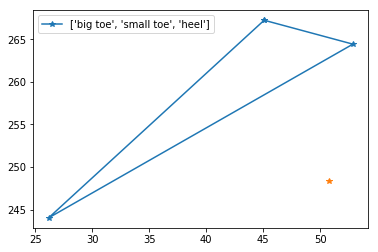

In [12]:
print (viz_file.iloc[9][right_foot_coordinates_x], viz_file.iloc[9][right_foot_coordinates_y])
plt.figure()
plt.plot(viz_file.iloc[9][right_foot_coordinates_x], viz_file.iloc[9][right_foot_coordinates_y], '*-', label = ['big toe', 'small toe', 'heel'])
plt.plot(viz_file.iloc[9]['treadmill_COP_x'], viz_file.iloc[9]['treadmill_COP_y'], '*')
plt.legend()